In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional, Union
from functools import reduce 
from pyntcloud import PyntCloud
from tqdm import tqdm
from matplotlib import rc

plt.rcParams["figure.figsize"] = (8, 6)
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 18})
# rc('text', usetex=True)
# rc('text.latex',preamble='\\usepackage[utf8]{inputenc}')
# rc('text.latex',preamble='\\usepackage[russian]{babel}')

In [4]:
COLOR_BLUE = '#2CBDFE'
COLOR_GREEN = '#47DBCD'
COLOR_PINK = '#F3A0F2'
COLOR_PURPLE = '#9D2EC5'
COLOR_VIOLET = '#661D98'
COLOR_AMBER = '#F5B14C'

COLORS = [COLOR_PURPLE, COLOR_AMBER, COLOR_GREEN, COLOR_PINK, COLOR_VIOLET, COLOR_BLUE]
def get_color(idx: int):
    return COLORS[idx % len(COLORS)]

In [5]:
def show_bar_plots(hists: np.ndarray, 
                   tick_labels: Optional[List[str]] = None,
                   legend_labels: Optional[List[str]] = None,
                   empty: float = 0.0,
                   ticks_rotation: str = 'horizontal',
                   ylabel: Optional[str] = None,
                   xlabel: Optional[str] = None,
                   horizontal=False):
    if len(hists.shape) == 2:
        n, m = hists.shape
        x = np.arange(m)
        f, ax = plt.subplots(figsize=(25, 5))
        for i, y in enumerate(hists):
            width = (1 - empty) / n
            shift = (i + 0.5) * width - 0.5
            if not horizontal:
                ax.bar(x + shift, y, width=width, align='center', 
                       tick_label=tick_labels if i == len(hists) // 2 else None, label=f'{legend_labels[i]}: {np.mean(y)}', color=get_color(i))
            else:
                ax.barh(x + shift, y, height=width, align='center', 
                        tick_label=tick_labels if i == len(hists) // 2 else None, label=f'{legend_labels[i]}: {np.mean(y)}', color=get_color(i))
    else:
        l, n, m = hists.shape
        x = np.arange(m)
        f, ax = plt.subplots(figsize=(40, 16) if horizontal else (30, 8))
        for j in range(l):
            for i, y in enumerate(hists[j]):
                width = (1 - empty) / n
                shift = (i + 0.5) * width - 0.5
                if not horizontal:
                    ax.bar(x + shift, y, width=width, align='center', 
                           tick_label=tick_labels if i == len(hists) // 2 else None, label=f'{legend_labels[i]}: {np.mean(y)}', color=get_color(j * n + i))
                else:
                    ax.barh(x + shift, y, height=width, align='center', 
                            tick_label=tick_labels if i == len(hists) // 2 else None, label=f'{legend_labels[i]}: {np.mean(y)}', color=get_color(j * n + i))
    plt.xticks(rotation=ticks_rotation)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=4, mode="expand", borderaxespad=0.)
    ax.set_axisbelow(True)
    ax.yaxis.grid(linestyle = '--', linewidth = 0.5) # horizontal lines 
    # plt.savefig(f'{ylabel}.png', bbox_inches='tight', dpi=200)
    plt.show()
    
def plot_line_graph(df, parameter_x, parameter_y, versions, descriptors=['fpfh', 'rops', 'shot']):
    for v in versions:
        for d in descriptors:
            df_local = df[(df['version'] == v) & (df['descriptor'] == d)]
            plt.plot(df_local[parameter_x].values, df_local[parameter_y].values, label=d + f' ({v})')
            plt.legend()
    plt.show()

In [6]:
def show_distances(path, thr=1.5, k=0):
    df = pd.read_csv(path)
    dists = np.sort(df.values.flatten())[-k:]
    print('Number of good correspondences:', np.count_nonzero(dists < thr))
    plt.fill_between(np.arange(len(dists)), np.zeros_like(dists), dists, facecolor='blue', alpha=0.5)
    plt.hlines(thr, 0, len(dists) - 1, color='r')
    plt.show()

In [7]:
def show_uniquenesses(path, a_max=300):
    df = pd.read_csv(path)
    dists = df.values.flatten()
    dists = np.clip(np.sort(dists), a_min=0, a_max=a_max)
    plt.hist(dists, bins='fd')
    plt.show()

In [8]:
def min_confusion_matrix(hists1, hists2):
    xx, yy = np.meshgrid(np.arange(len(hists1)), np.arange(len(hists2)))
    return np.abs(np.stack((hists1[xx], hists2[yy]), axis=3).min(axis=3)).sum(axis=2)

def l2_confusion_matrix(hists1, hists2):
    xx, yy = np.meshgrid(np.arange(len(hists1)), np.arange(len(hists2)))
    return np.sqrt(((hists1[xx] - hists2[yy]) ** 2).sum(axis=2))
    
def cosine_confusion_matrix(hists1, hists2):
    xx, yy = np.meshgrid(np.arange(len(hists1)), np.arange(len(hists2)))
    return np.sqrt((hists1[xx] * hists2[yy]).sum(axis=2))
    
def show_confusion_matrix(confusion_matrix, labels1=None, labels2=None, vmin=None, vmax=None):
    fig, ax = plt.subplots(figsize=(20, 20))
    res = ax.imshow(confusion_matrix, cmap=plt.cm.jet, vmin=vmin, vmax=vmax, interpolation='nearest')
    fig.colorbar(res)
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(j, i, '{:.2f}'.format(confusion_matrix[i,j]), ha='center', va='center', color='w')
   
    if labels1 is not None: 
        ax.tick_params(labelbottom=False,labeltop=True)
        ax.set_xticks(range(len(labels1)), labels1, rotation='vertical')
    if labels2 is not None:
        ax.set_yticks(range(len(labels2)), labels2)
    plt.show()

In [9]:
def skip_zeros(hist1, hist2):
    mask = ~np.logical_and(hist1 == 0, hist2 == 0)
    return hist1[mask], hist2[mask]

def analyze_descriptors(path_src, path_tgt, ids_src, ids_tgt, descriptor_size, confusion_matrix_fn, descriptions=[], vmin=None, vmax=None):
    hists_src = pd.read_csv(path_src, header=None, usecols=np.arange(descriptor_size + 1).tolist())
    hists_tgt = pd.read_csv(path_tgt, header=None, usecols=np.arange(descriptor_size + 1).tolist())
    hists_src.drop(columns=[0], inplace=True)
    hists_tgt.drop(columns=[0], inplace=True)
    for id_src, id_tgt in zip(ids_src, ids_tgt):
        hist_src = hists_src.iloc[id_src].values
        hist_tgt = hists_tgt.iloc[id_tgt].values
        show_bar_plots(np.vstack((hist_src, hist_tgt)), legend_labels=[f'src, {np.linalg.norm(hist_src - hist_tgt)}', 'tgt'])
    
    confusion_matrix = confusion_matrix_fn(hists_src.values, hists_tgt.values)
    show_confusion_matrix(confusion_matrix_fn(hists_src.iloc[ids_src].values, hists_tgt.iloc[ids_tgt].values),
                          descriptions,
                          descriptions,
                          vmin=vmin, vmax=vmax) 
    show_confusion_matrix(confusion_matrix_fn(hists_src.iloc[ids_src].values, hists_src.iloc[ids_src].values),
                          descriptions,
                          descriptions,
                          vmin=vmin, vmax=vmax) 
    show_confusion_matrix(confusion_matrix_fn(hists_tgt.iloc[ids_tgt].values, hists_tgt.iloc[ids_tgt].values),
                          descriptions,
                          descriptions,
                          vmin=vmin, vmax=vmax) 

In [10]:
def get_label(t: Tuple) -> str:
    if len(t) == 1:
        return t[0]
    return '(' + ', '.join() + ')'
    
    
def analyze_by(df, by: str, methods: List[str], analyzed_parameters: List[Union[str, Tuple]], descriptors=['shot', 'rops'],  ticks_rotation='horizontal', horizontal=False, y_labels=None, x_label=None):
    for desc in descriptors:
        df_desc = df[df['descriptor'] == desc]
        testnames = list(sorted(reduce(np.intersect1d, [df_desc[df_desc[by] == method]['testname'].values for method in methods])))
        df_desc = df_desc[df_desc['testname'].isin(testnames)]
        df_desc = df_desc.sort_values('testname')
        n, m = len(methods), len(testnames)
        if m == 0:
            continue
        for k, ps in enumerate(analyzed_parameters):
            if type(ps) is not tuple:
                ps = (ps,)
            hists = np.zeros((len(ps), n, m))
            for l, p in enumerate(ps):
                for i, method in enumerate(methods):
                    for j, testname in enumerate(testnames):
                        hists[l, i, j] = df_desc[(df_desc['testname'] == testname) & (df_desc[by] == method)][p].values[0]  
            y_label= get_label(ps) if y_labels is None else y_labels[k]
            show_bar_plots(hists, testnames, methods, empty=0.5, ticks_rotation=ticks_rotation, ylabel=y_label, xlabel=x_label, horizontal=horizontal)

In [11]:
from pandas.api.types import is_numeric_dtype

def highlight_names(s):
    s_unique = s.unique()
    d = {name: s for s, name in enumerate(sorted(s_unique))}
    return ['background-color: ' + ('moccasin' if d[name] % 2 == 0 else 'coral') for name in s]


def display_colored(df, columns=[], cmap='PuBu', qmin=0.2, qmax=0.8, str_columns=[]):
    filtered_columns =  list(filter(lambda c: c in df.columns and is_numeric_dtype(df[c]), columns))
    styler = df.style
    for column in filtered_columns:
        styler.background_gradient(subset=[column], cmap=cmap, vmin=df[column].quantile(qmin), vmax=df[column].quantile(qmax))
    for str_column in str_columns:
        styler.apply(highlight_names, subset=[str_column])
    display(styler)

In [12]:
def build_prc(distances_list: List[np.ndarray], masks: List[np.ndarray], thrs: List[float], legends: List[str], reverse=False):
    figs, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
    for distances, mask, legend in zip(distances_list, masks, legends):
        if reverse:
            distances = 1.0 - distances  
        precision = []
        recall = []
        f1 = []
        for thr in thrs:
            tp = np.count_nonzero(mask & (distances <= thr))
            fp = np.count_nonzero(~mask & (distances <= thr))
            fn = np.count_nonzero(mask & (distances > thr))
            recall.append(tp / (tp + fn))
            if tp == 0:
                precision.append(0.0)
                f1.append(0.0)
            else:
                precision.append(tp / (fp + tp))
                f1.append(2 * precision[-1] * recall[-1] / (precision[-1] + recall[-1]))
            for ax in axes[:2]:
                ax.axvline(x=thr, color='gray', linestyle='-.', alpha=0.1, linewidth=0.5)
        axes[0].plot(thrs, precision, label=legend)
        axes[1].plot(thrs, recall, label=legend)
        axes[2].plot(recall, precision, label=legend)
        axes[3].plot(thrs, f1, label=legend)
    axes[0].set_xlabel('threshold')
    axes[1].set_xlabel('threshold')
    axes[2].set_xlabel('recall')
    axes[3].set_xlabel('threshold')
    axes[0].set_ylabel('precision')
    axes[1].set_ylabel('recall')
    axes[2].set_ylabel('precision')
    axes[3].set_ylabel('f1 score')
    axes[0].legend()
    axes[1].legend()
    axes[2].legend()
    axes[3].legend()
    plt.show()

In [14]:
# df = pd.read_csv('data/debug/test_hypotheses.csv')
# df = df.sort_values(['testname', 't_err'])

# testnames = df['testname'].values.flatten()
# testnames = testnames[np.sort(np.unique(testnames, return_index=True)[1])]
# for testname in testnames:
#     df_gt = df[(df['testname'] == testname) & (df['id'] == 'gt')]
#     df_hs = df[(df['testname'] == testname) & (df['id'] != 'gt')].copy()
#     df_hs['order'] = np.argsort(df_hs['mse'].values)[::-1]
#     for column in ['inliers', 'mse', 'inliers_area', 'uniformity', 'overlap', 'overlap_area']:
#         df_hs[column] = df_hs[column] / df_gt[column].values[0]
#     df_hs = df_hs[:4].sort_values('uniformity', ascending=False)
#     display_colored(df_hs, ['r_err', 't_err', 'inliers', 'mse', 'inliers_area', 'uniformity', 'overlap', 'overlap_area'], cmap='YlGnBu', qmin=0.1, qmax=0.9, str_columns=['testname'])
# display_colored(df, ['r_err', 't_err', 'inliers', 'mse', 'inliers_area', 'uniformity', 'overlap', 'overlap_area'], cmap='YlGnBu', qmin=0.1, qmax=0.9, str_columns=['testname'])

In [152]:
df = pd.read_csv('data/debug/test_results.csv')
df = df[(df['version'] == 17) & (df.index > 1870) & (df['testname'].apply(lambda s: s.startswith('kig')))]
df_overlapping = pd.read_csv('data/kizhi/downsampled_0.05/overlapping.csv')
testnames = df['testname'].values.flatten()
testnames = testnames[np.sort(np.unique(testnames, return_index=True)[1])]
df['overlap_gt'] = 0.0
df['success'] = ((df['overlap_rmse'] < 0.5) & (df['t_err'] < 0.5)).astype(float)
for testname in testnames:
    f1 = testname[:testname.find('_kig')] + '.ply'
    f2 = testname[testname.find('_kig') + 1:] + '.ply'
    df['overlap_gt'] = df['overlap_gt'].where(~(df['testname'] == testname), df_overlapping[df_overlapping['reading'] == f1][[f2]].values.flatten()[0])
columns = ['metric', 'overlap', 'overlap_area', 'correspondences', 'inliers',
           'correct_correspondences', 'correct_inliers', 'iteration', 'overlap_gt',
           'r_err', 't_err', 'overlap_rmse',
           'time_cs', 'time_te', 'converged', 'success']
df = df[['testname'] + columns]

In [153]:
display_colored(df, columns, cmap='YlGnBu', qmin=0.1, qmax=0.9, str_columns=['testname'])

In [157]:
float('inf') == float('inf')

True

### All tests

TP: 150
FN: 13
TN: 250
FP: 64


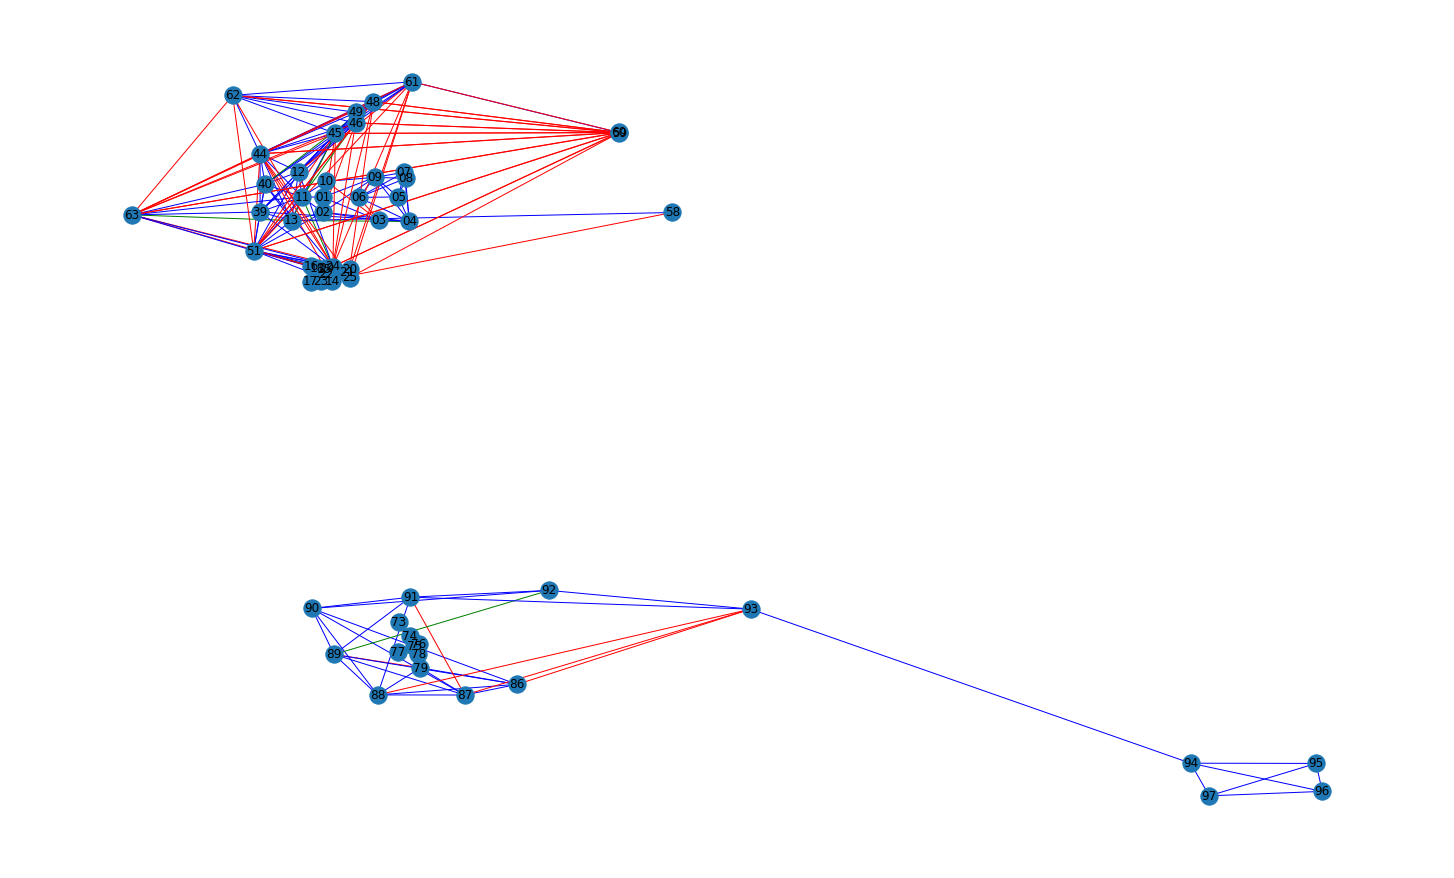

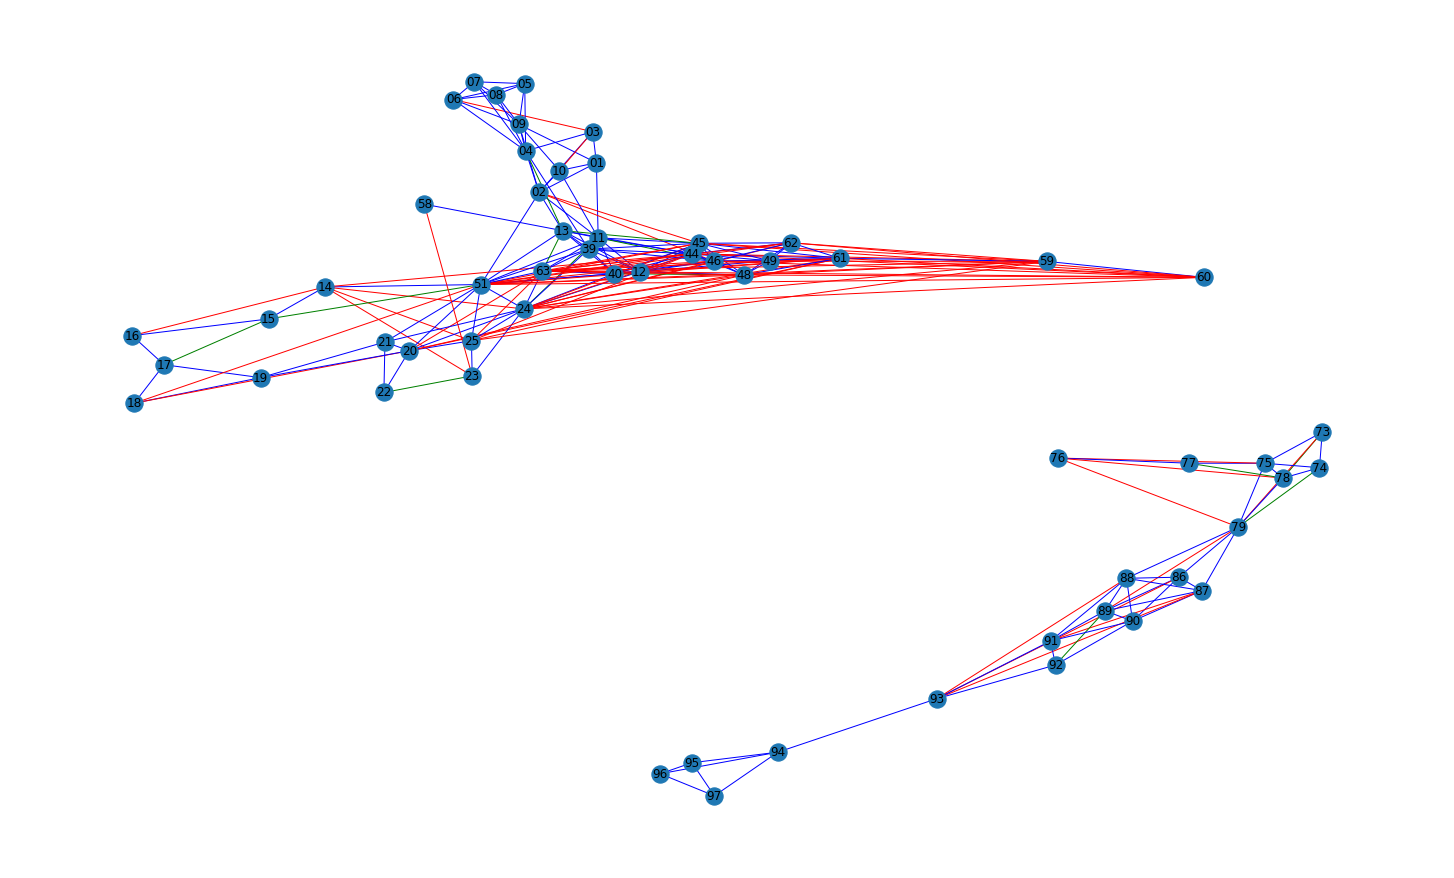

In [155]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

G = nx.Graph()
df_gt = pd.read_csv('data/kizhi/ground_truth.csv')
for f, x, y in df_gt[['reading', 'gT03', 'gT13']].values:
    if len(df_overlapping[df_overlapping['reading'] == f]) > 0:
        v = f[f.find('_0') + 2:]
        v = v[:v.find('_')]
        G.add_node(v, pos=(x, y))

print('TP:', np.count_nonzero((df['converged'] == 1.0) & (df['success'] == 1.0)))
print('FN:', np.count_nonzero((df['converged'] == 0.0) & (df['success'] == 1.0)))
print('TN:', np.count_nonzero((df['converged'] == 0.0) & (df['success'] == 0.0)))
print('FP:', np.count_nonzero((df['converged'] == 1.0) & (df['success'] == 0.0)))

for testname in testnames:
    v1 = testname[testname.find('_0') + 2:]
    v1 = v1[:v1.find('_')]
    v2 = testname[testname.find('_kig') + 6:]
    v2 = v2[:v2.find('_')]
    df_test = df[df['testname'] == testname]
    success = df_test['success'].values.flatten()[0]
    converged = df_test['converged'].values.flatten()[0]
    if success == 1.0:
        G.add_edge(v1, v2, color='b' if converged == 1.0 else 'g')

pos1=nx.get_node_attributes(G,'pos')
pos2 = nx.spring_layout(G, k=0.2, scale=2, seed=13)

for testname in testnames:
    v1 = testname[testname.find('_0') + 2:]
    v1 = v1[:v1.find('_')]
    v2 = testname[testname.find('_kig') + 6:]
    v2 = v2[:v2.find('_')]
    df_test = df[df['testname'] == testname]
    success = df_test['success'].values.flatten()[0]
    converged = df_test['converged'].values.flatten()[0]
    if success == 0.0 and converged == 1.0:
        G.add_edge(v1, v2, color='r')

colors = nx.get_edge_attributes(G,'color').values()

plt.figure(1, figsize=(20,12))
nx.draw(G, pos1, edge_color=colors, with_labels=True)
plt.show()

plt.figure(2, figsize=(20,12))
nx.draw(G, pos2, edge_color=colors, with_labels=True)
plt.show()


In [89]:
# mask = df['testname'].apply(lambda s: '22_21' in s)
display_colored(df, columns, cmap='YlGnBu', qmin=0.0, qmax=1.0, str_columns=['testname'])  

### Overlap region > 10%, error > 10 cm

In [111]:
df_bad = df[(df['overlap_gt'] > 0.15) & (df['success'] == 0.0)]
display_colored(df_bad, columns, cmap='YlGnBu', qmin=0.1, qmax=0.9, str_columns=['testname'])           

In [28]:
df = pd.read_csv('data/debug/test_hypotheses.csv')
df = df.sort_values(['testname', 't_err'])

testnames = df['testname'].values.flatten()
testnames = testnames[np.sort(np.unique(testnames, return_index=True)[1])]
for testname in ['SubwayStation3_SubwayStation5']:
    df_gt = df[(df['testname'] == testname) & (df['id'] == 'gt')]
    df_hs = df[(df['testname'] == testname) & (df['id'] != 'gt')].copy()
    df_hs['order'] = np.argsort(df_hs['mse'].values)[::-1]
    df_hs['id'] = pd.to_numeric(df_hs['id'])
    for column in ['inliers', 'mse', 'inliers_area', 'uniformity', 'overlap', 'overlap_area']:
        df_hs[column] = df_hs[column] / df_gt[column].values[0]
    print(len(df_hs))
    df_hs = df_hs.drop_duplicates(['t_err', 'r_err']).sort_values('id', ascending=True).reset_index()
    print(len(df_hs))
    display_colored(df_hs, ['r_err', 't_err', 'inliers', 'mse', 'inliers_area', 'uniformity', 'overlap', 'overlap_area'], cmap='YlGnBu', qmin=0.1, qmax=0.9, str_columns=['testname'])

845
836


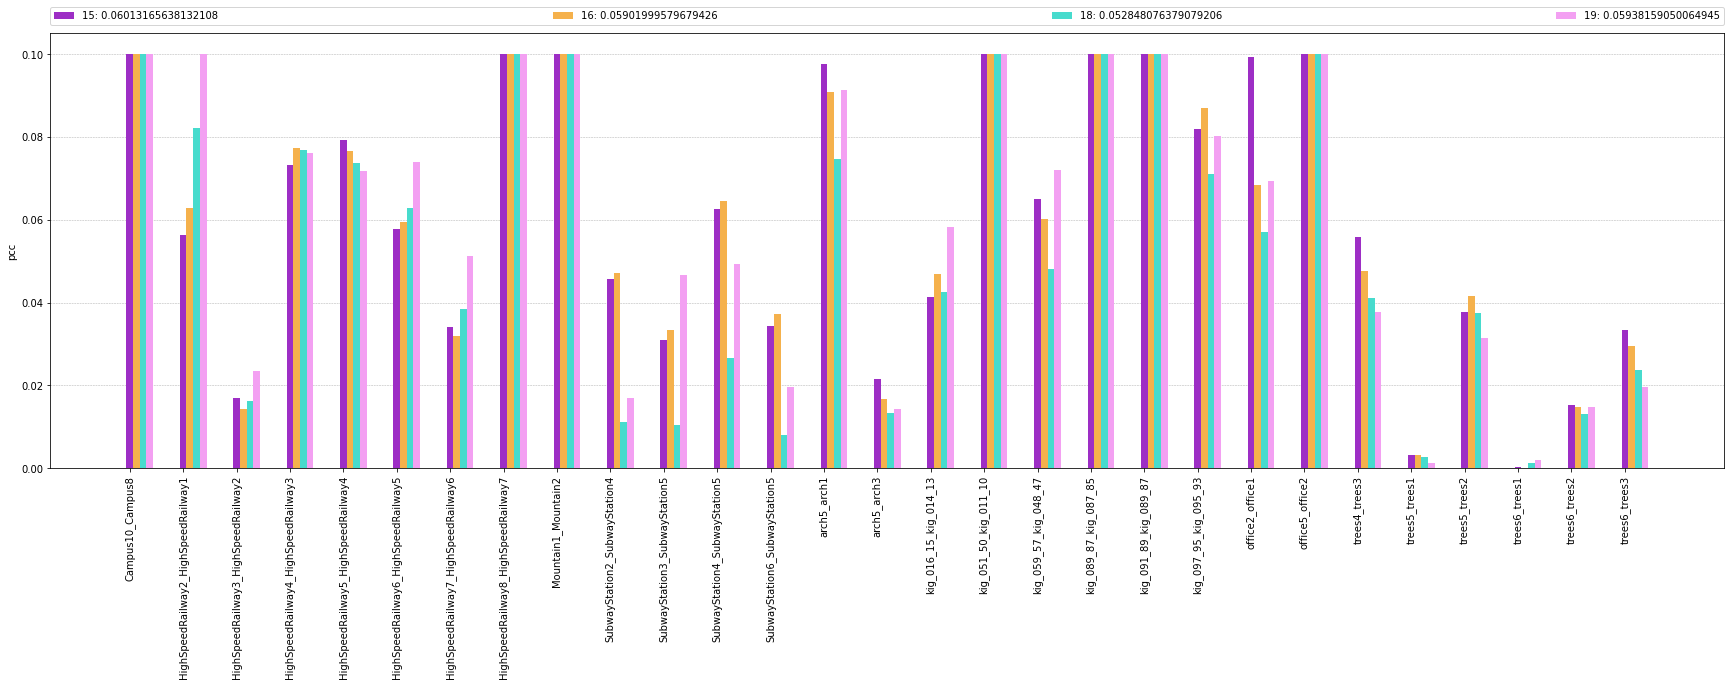

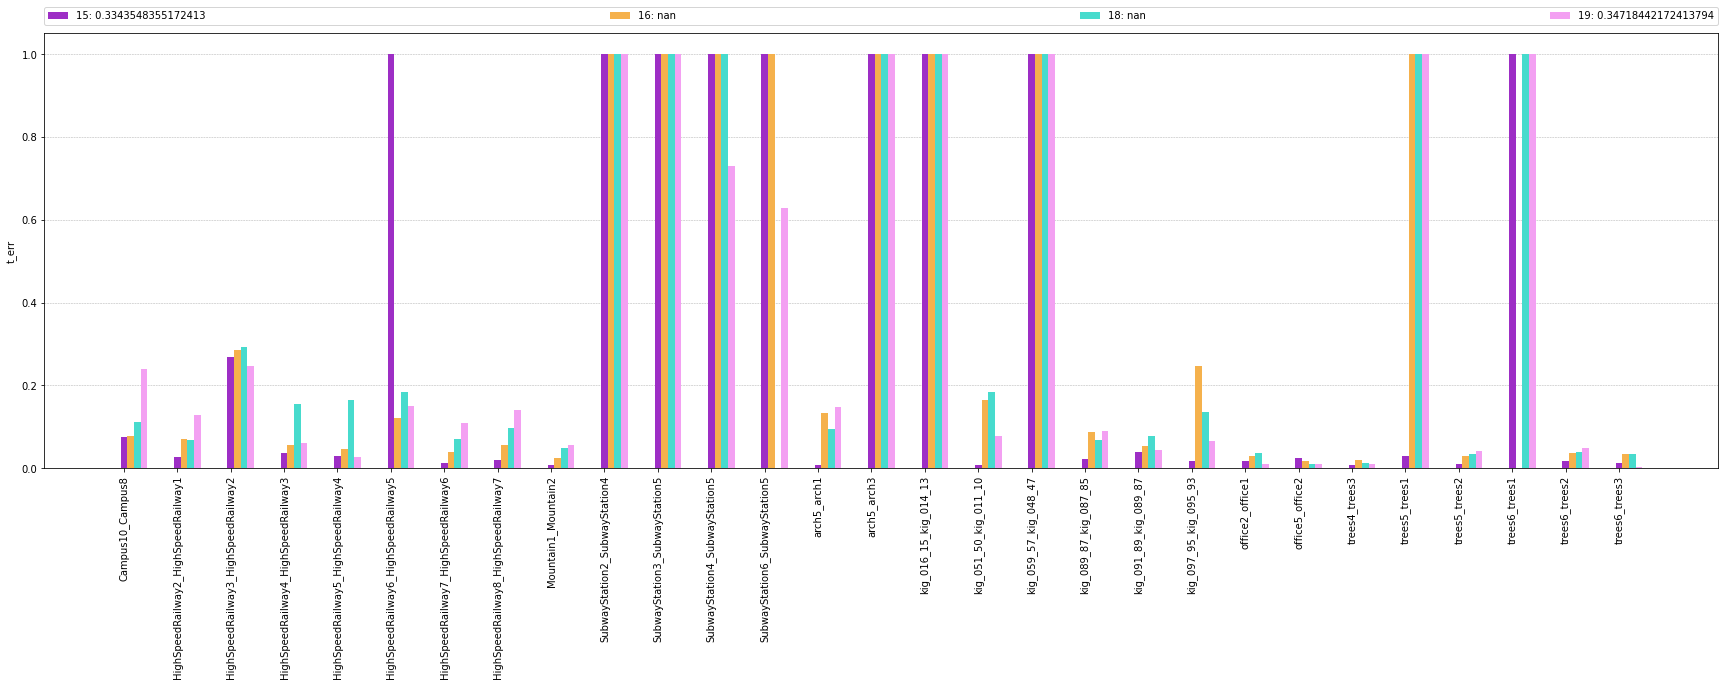

In [138]:
df = pd.read_csv('data/debug/test_results.csv')
# df['index'] = df.index
# df = df[(df['version'] != 15) | (df['distance_thr'] / df['iss_radius'] == 2.0)]
df['pcc'] = df['correct_correspondences'] / df['correspondences']
# print('%i/%i converged' % (len(df[df['version'] == 15]), len(df[df['version'] == 14])))
df['pcc'] = np.minimum(df['pcc'], 0.1)
df['t_err'] = np.minimum(df['t_err'], 1.0)
df['correct_correspondences'] = np.minimum(df['correct_correspondences'], 1000)
# df['version'] = df['version'].where(~(df['index'] > 1290), 16)

# analyze_by(df, 'version', [14], analyzed_parameters=['overlap_rmse'], descriptors=['shot'], ticks_rotation='vertical')
analyze_by(df, 'version', [15, 16, 18, 19], analyzed_parameters=['pcc', 't_err'], descriptors=['shot'], ticks_rotation='vertical')

## Analyzing cluster filtering

### k neighbors

In [ ]:
df = pd.read_csv('data/debug/test_results.csv')
df = df[(df['version'] == 14) & (df['matching'] == 'cluster')]
testnames = df['testname'].values.flatten()
testnames = testnames[np.sort(np.unique(testnames, return_index=True)[1])]
tns = pd.read_csv('data/debug/transformations.csv')

for testname in testnames:
    for iss_coef in ['0.500000', '0.250000']:
        print(f'{testname}, iss_coef = {iss_coef}')
        distances_list = []
        masks = []
        legends = []
        for cluster_k in [10, 20, 40, 80, 160]:
            tn = tns[tns['reading'] == f'{testname}_transformation_gt_352_shot_bf_default_iss_gravity_correspondences_mse_cluster_1_30_1_{iss_coef}_2.000000_{cluster_k}_14'].values.flatten()[1:].astype(float).reshape((4, 4))
            df_corrs = pd.read_csv(f'data/debug/{testname}/{testname}_correspondences_352_shot_bf_default_iss_gravity_cluster_1_30_1_{iss_coef}_2.000000_{cluster_k}_14.csv')
            source_points = (tn[:3, :3] @ df_corrs[['x_s', 'y_s', 'z_s']].values.T).T + tn[:3, 3]
            target_points = df_corrs[['x_t', 'y_t', 'z_t']].values
            distances_l2 = np.linalg.norm(source_points - target_points, axis=1)
            distance_thr = float(df[df['testname'] == testname]['distance_thr'].values.flatten()[0])
            distances = df_corrs['distance'].values
            distances_list.append(distances)
            mask = distances_l2 < distance_thr
            masks.append(mask)
            legends.append(f'cluster_k = {cluster_k}')
            for cluster_thr in [0.9, 0.95, 0.975]:
                count_correct = np.count_nonzero(mask)
                count_tp = np.count_nonzero((distances < cluster_thr) & mask)
                count_p = np.count_nonzero(distances < cluster_thr)
                print(f'{count_correct}/{len(mask)} [{count_correct/len(mask)}] --> cluster_k = {cluster_k}, cluster_thr = {cluster_thr}, {count_tp}/{count_p} [{count_tp/count_p}] correct correspondences')
            print()
        build_prc(distances_list, masks, 0.4 + 0.6 * np.arange(40) / 40, legends)
        

## Analyzing number of points for normal estimation and neccessity to reestimate lrfs
### number of points

In [ ]:
nrs = [10, 30, 50]
df = pd.read_csv('data/debug/test_results.csv')
df = df[df['version'] == 14]
testnames = np.unique(df['testname'].values.flatten())
all_data = []
for testname in testnames:
    data = []
    for nr_normal_points in nrs:
        values = pd.read_csv(f'data/debug/{testname}/{testname}_median_norm_diff_352_shot_bf_gror_iss_gravity_ratio2_1_{nr_normal_points}_0_1.000000_14.csv').values.flatten()
        data.append(values)
    data = np.array(data).T
    data /= data[:, len(nrs) - 1:len(nrs)]
    medians =  np.median(data, axis=0)
    for i, nr in enumerate(nrs):
        all_data.append([testname, nr, medians[i]])
df = pd.DataFrame(all_data, columns=['testname', 'nr', 'norm_diff_ratio'])
df['descriptor'] = 'shot'
analyze_by(df, 'nr', nrs, analyzed_parameters=['norm_diff_ratio'], descriptors=['shot'], ticks_rotation='vertical')

df = pd.read_csv('data/debug/test_results.csv')
df = df[(df['version'] == 14) & (df['reestimate'] == 1)]
df['pcc'] = df['correct_correspondences'] / df['correspondences']
df = df[df['pcc'] < 0.05]

analyze_by(df, 'normal_nr_points', nrs, analyzed_parameters=['pcc'], descriptors=['shot'], ticks_rotation='vertical')

### reestimation of lrfs

In [ ]:
nrs = [10, 30, 50]
df = pd.read_csv('data/debug/test_results.csv')
df = df[df['version'] == 14]
testnames = np.unique(df['testname'].values.flatten())
all_data = []
for testname in testnames:
    data = []
    for nr_normal_points in nrs:
        values_without = pd.read_csv(f'data/debug/{testname}/{testname}_median_norm_diff_kps_352_shot_bf_gror_iss_gravity_ratio2_1_{nr_normal_points}_0_1.000000_14.csv').values.flatten()
        values_with = pd.read_csv(f'data/debug/{testname}/{testname}_median_norm_diff_kps_352_shot_bf_gror_iss_gravity_ratio2_1_{nr_normal_points}_1_1.000000_14.csv').values.flatten()
        data.append(values_with / values_without)
    data = np.array(data).T
    medians = np.median(data, axis=0)
    for i, nr in enumerate(nrs):
        all_data.append([testname, nr, medians[i]])

df = pd.DataFrame(all_data, columns=['testname', 'nr', 'reestimate_norm_diff_ratio'])
df['descriptor'] = 'shot'
analyze_by(df, 'nr', nrs, analyzed_parameters=['reestimate_norm_diff_ratio'], descriptors=['shot'], ticks_rotation='vertical')

all_data = []
df = pd.read_csv('data/debug/test_results.csv')
df = df[df['version'] == 14]
for testname in testnames:
    for nr in nrs:
        df0 = df[(df['testname'] == testname) & (df['normal_nr_points'] == nr) & (df['reestimate'] == 0)]
        df1 = df[(df['testname'] == testname) & (df['normal_nr_points'] == nr) & (df['reestimate'] == 1)]
        pcc0 = (df0['correct_correspondences'] / df0['correspondences']).values[0]
        pcc1 = (df1['correct_correspondences'] / df1['correspondences']).values[0]
        all_data.append([testname, nr, pcc1 / pcc0])
df = pd.DataFrame(all_data, columns=['testname', 'nr', 'reestimate_pcc_ratio'])
df['descriptor'] = 'shot'
analyze_by(df, 'nr', nrs, analyzed_parameters=['reestimate_pcc_ratio'], descriptors=['shot'], ticks_rotation='vertical')

### iss coefficient

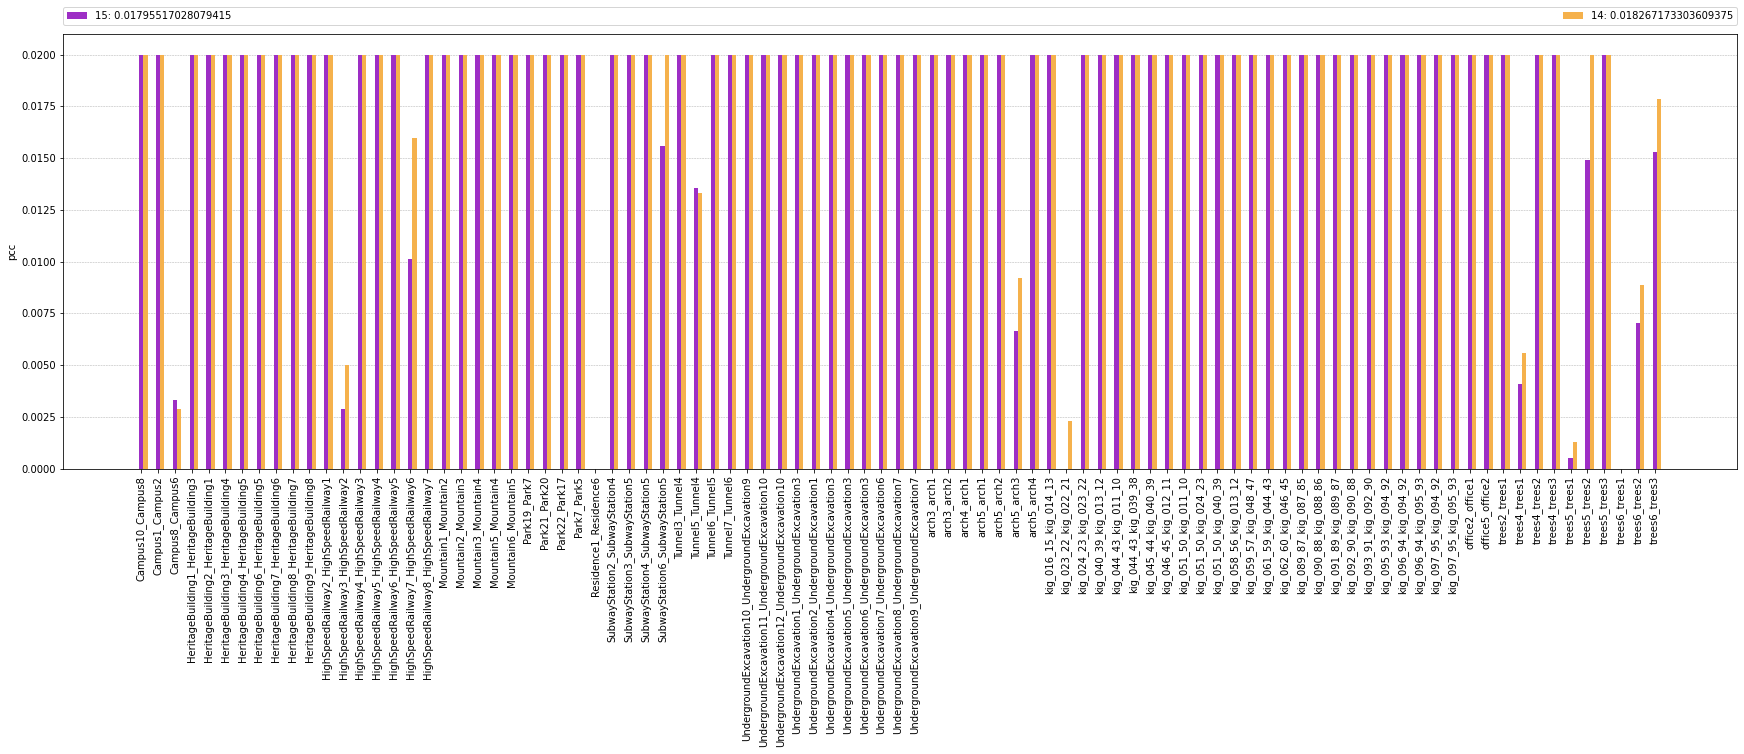

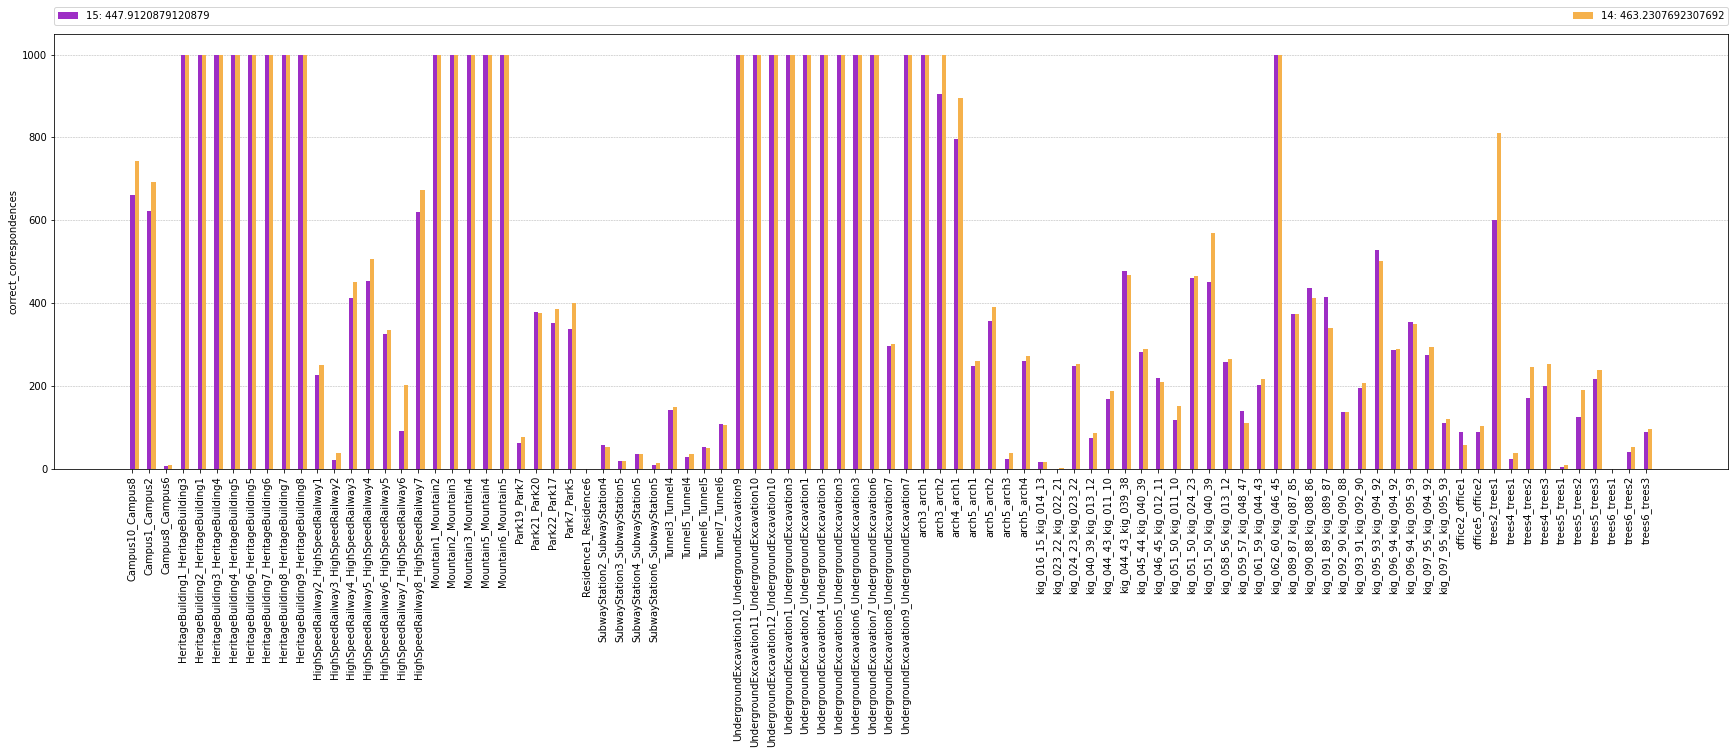

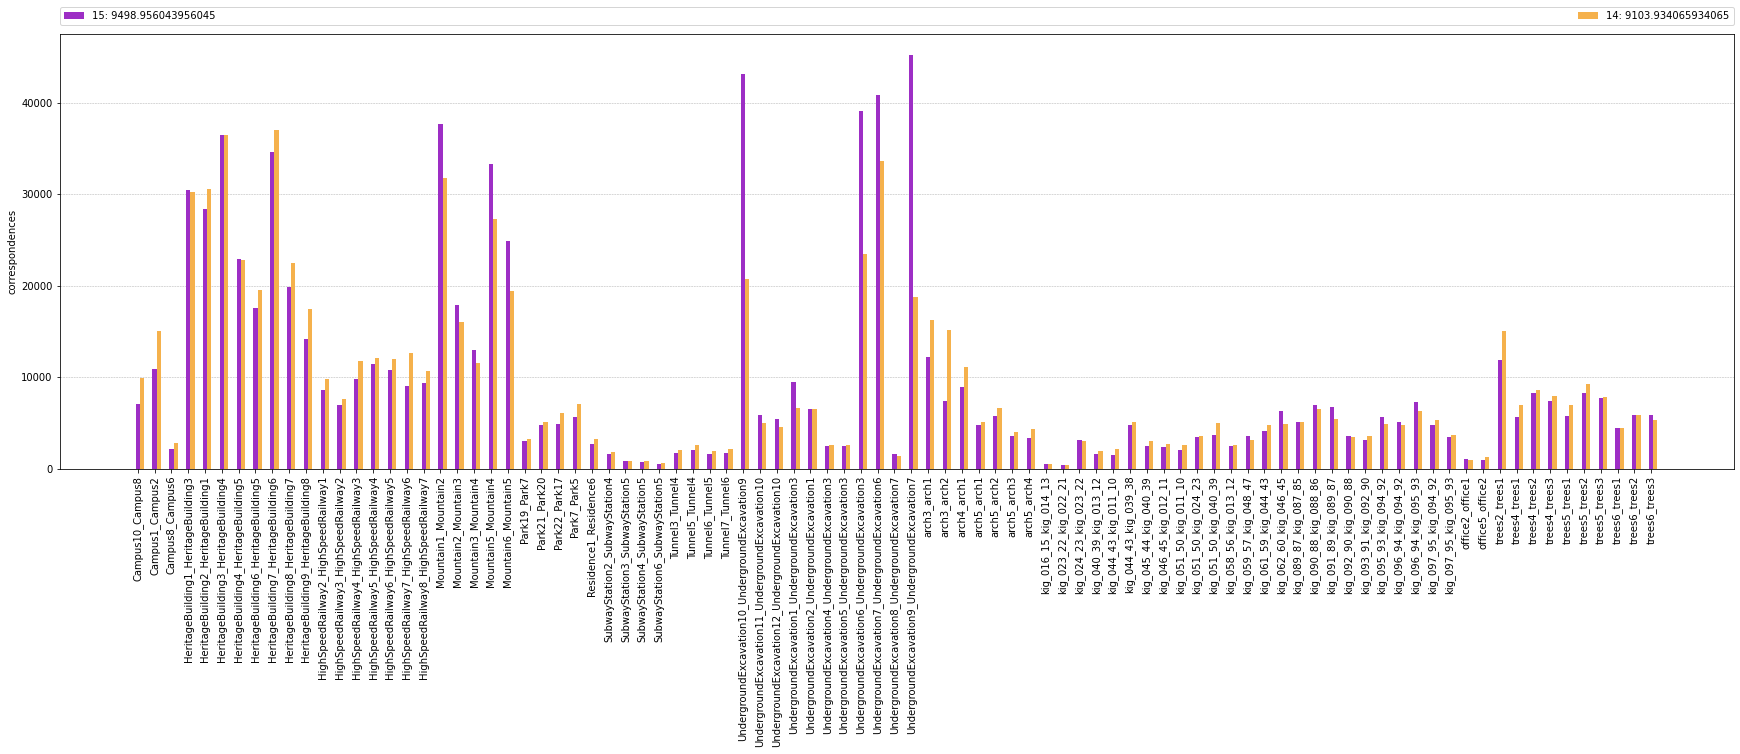

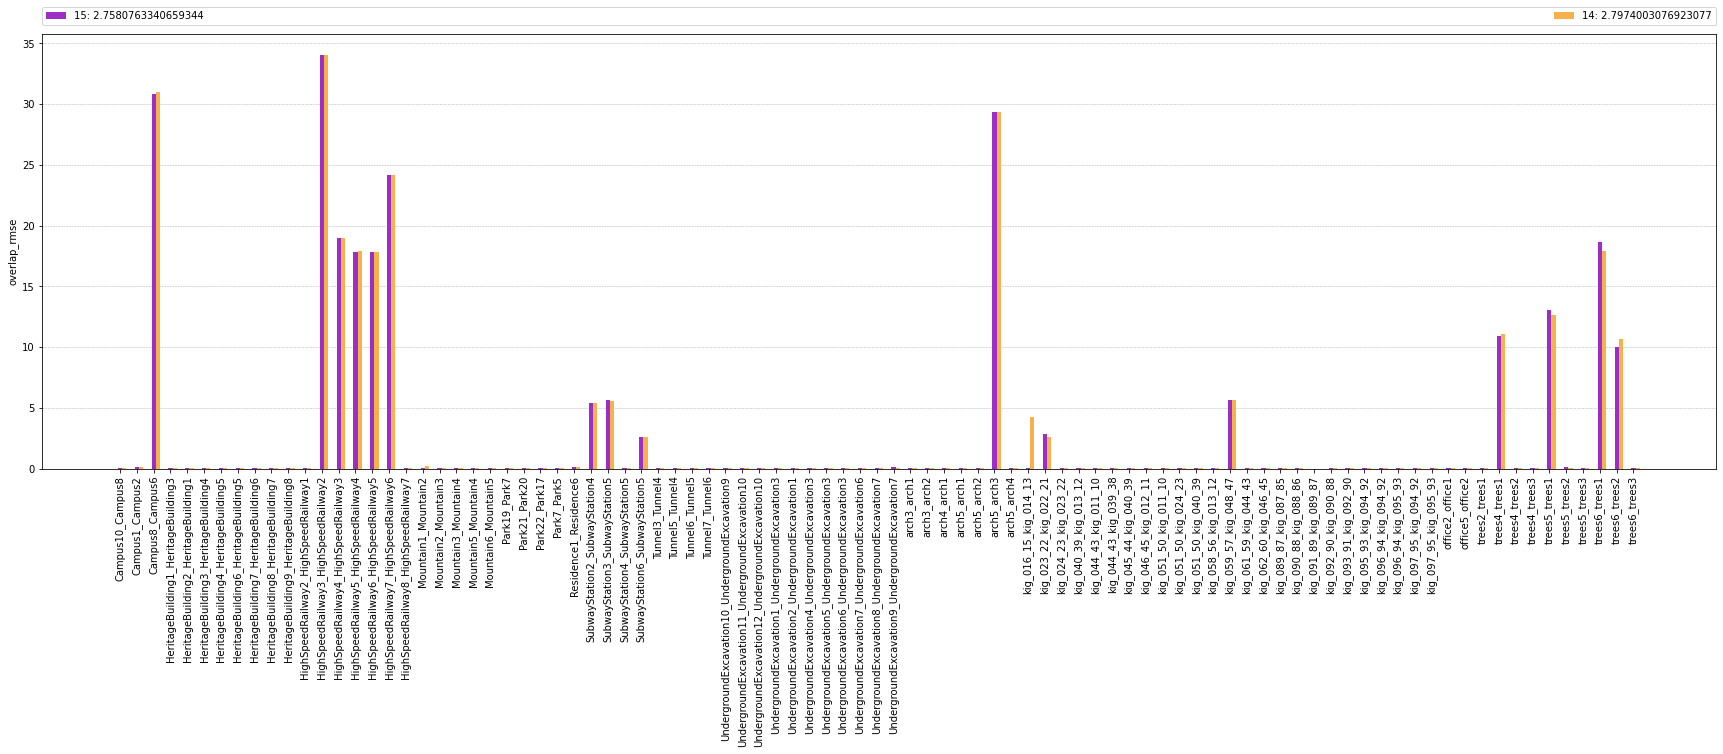

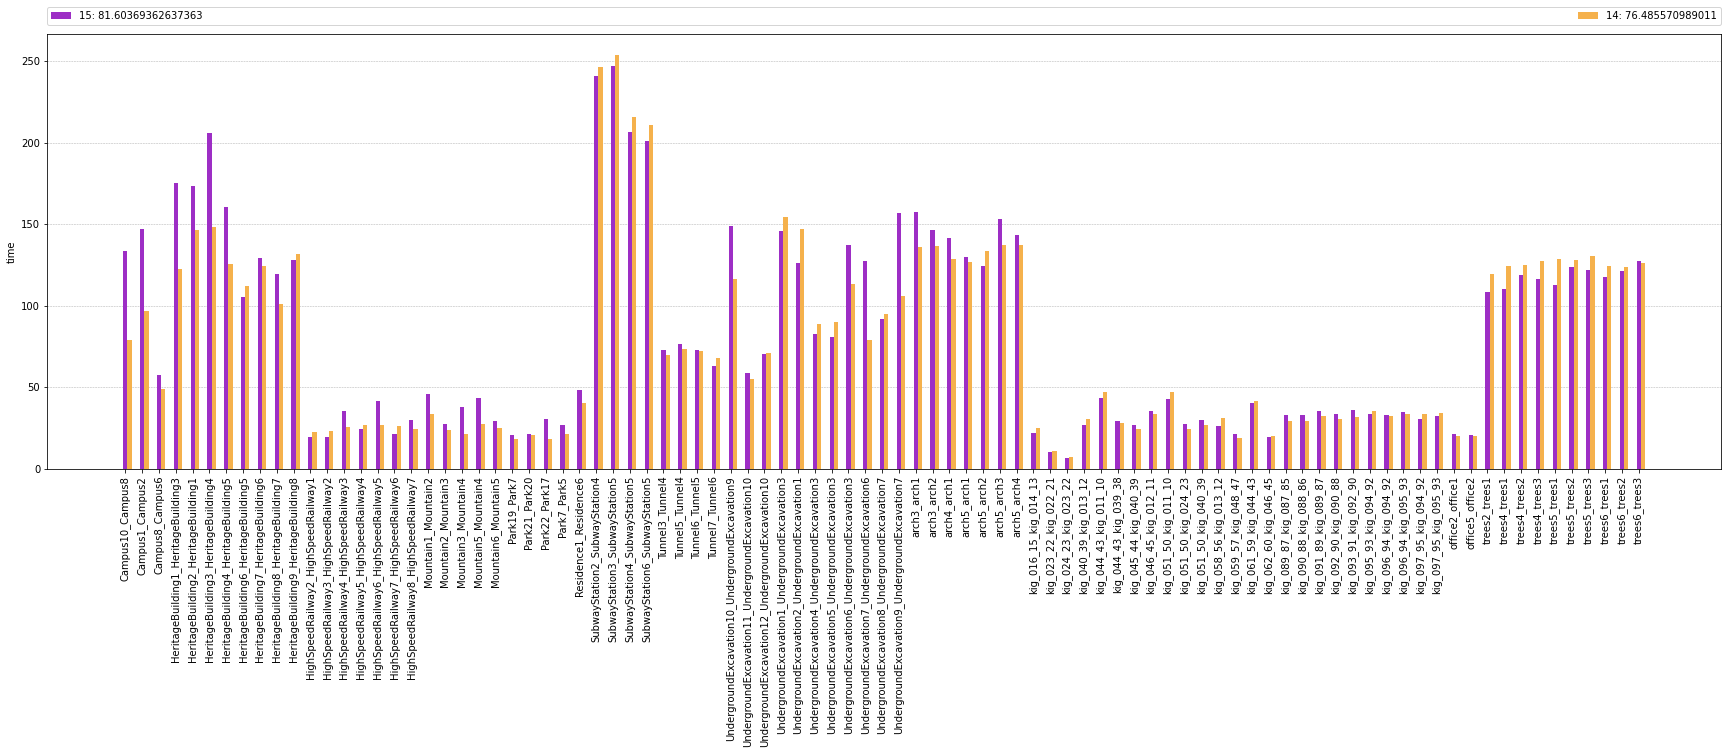

In [305]:
df = pd.read_csv('data/debug/test_results.csv')
df = df[((df['version'] == 14) | (df['version'] == 15)) & (df['distance_thr'] == df['iss_coef'])]
df['pcc'] = df['correct_correspondences'] / df['correspondences']
df['pcc'] = np.minimum(df['pcc'], 0.02)
df['correct_correspondences'] = np.minimum(df['correct_correspondences'], 1000)
analyze_by(df, 'version', [15, 14], analyzed_parameters=['pcc', 'correct_correspondences', 'correspondences', 'overlap_rmse', 'time'], descriptors=['shot'], ticks_rotation='vertical')

In [293]:
df1 = pd.read_csv('data/debug/trees5_trees1/trees5_trees1_ij_352_shot_bf_gror_iss_gravity_correspondences_mse_cluster_1_30_1_0.100000_2.000000_40_15.csv')[['2', '3']]
df2 = pd.read_csv('data/debug/trees5_trees1_ij_352_shot_bf_gror_iss_gravity_correspondences_mse_cluster_1_30_1_0.100000_2.000000_40_15.csv')[['2', '3']]
display(df1)
display(df2)
np.count_nonzero(df1.values != df2.values)

2         3
0      69145  0.460734
1        165  0.563608
2      64637  0.478193
3      25759  0.449104
4        681  0.485336
...      ...       ...
73890  35888  0.588421
73891  19529  0.512726
73892  50628  0.450240
73893  63325  0.493121
73894  63955  0.424135

[73895 rows x 2 columns]

2         3
0      69145  0.460734
1        165  0.563608
2      64637  0.478193
3      25759  0.449104
4        681  0.485336
...      ...       ...
73890  35888  0.588421
73891  19529  0.512726
73892  50628  0.450240
73893  63325  0.493121
73894  63955  0.424135

[73895 rows x 2 columns]

0

iss radii: [0.1 0.2]


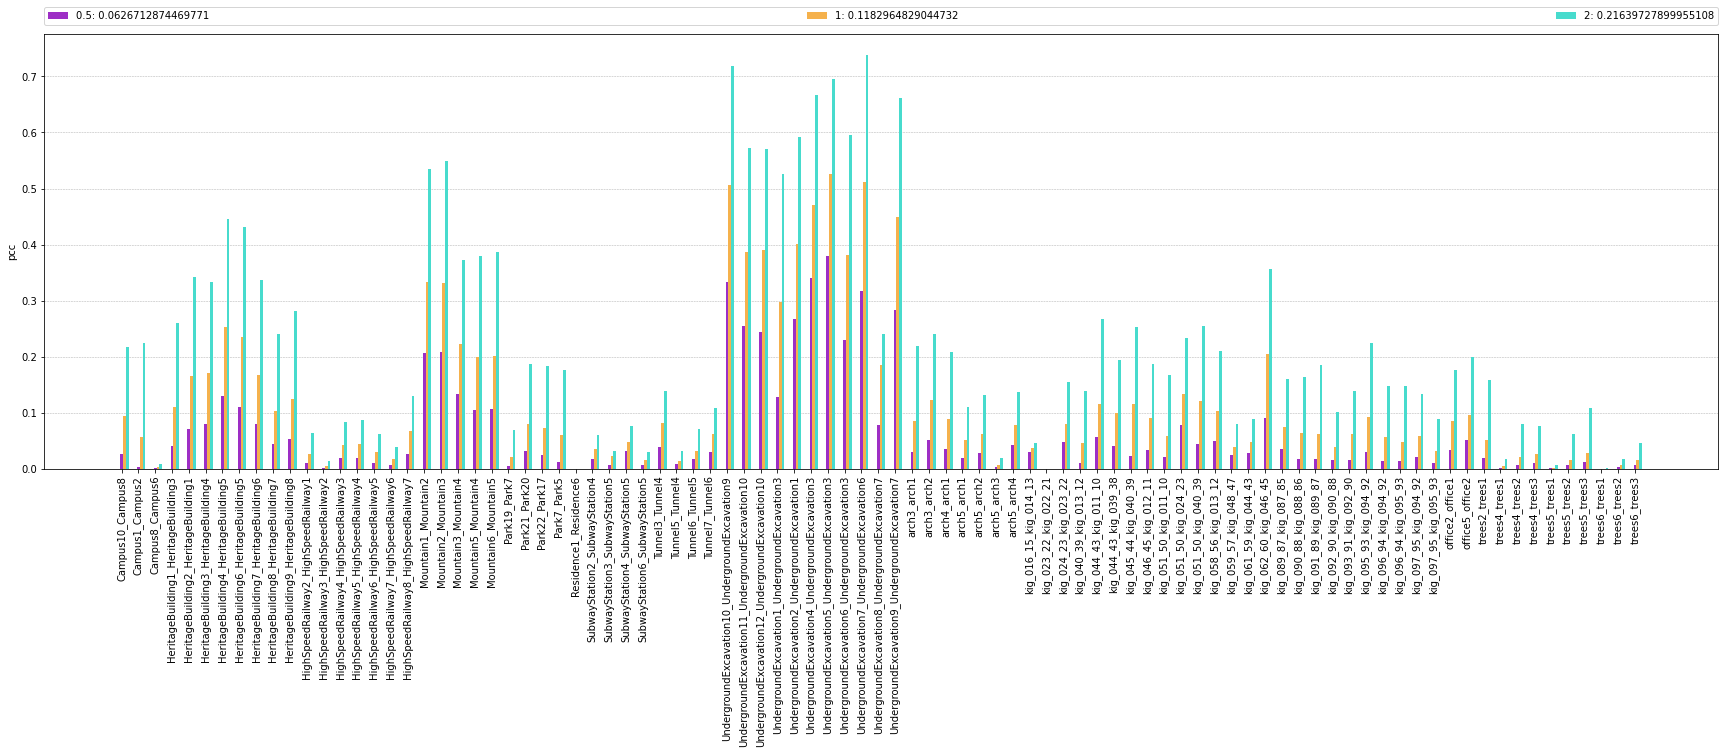

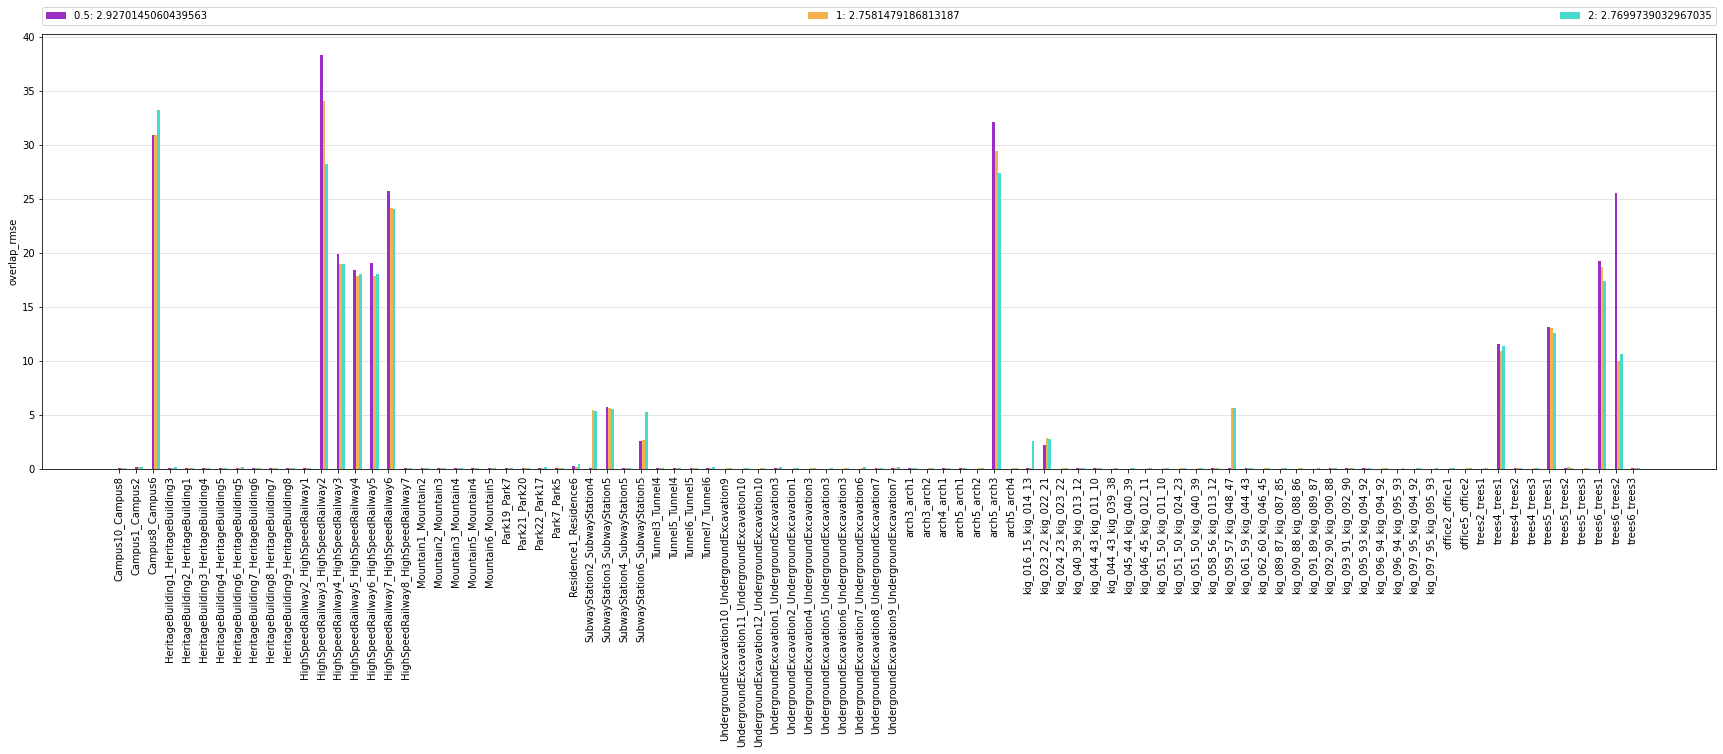

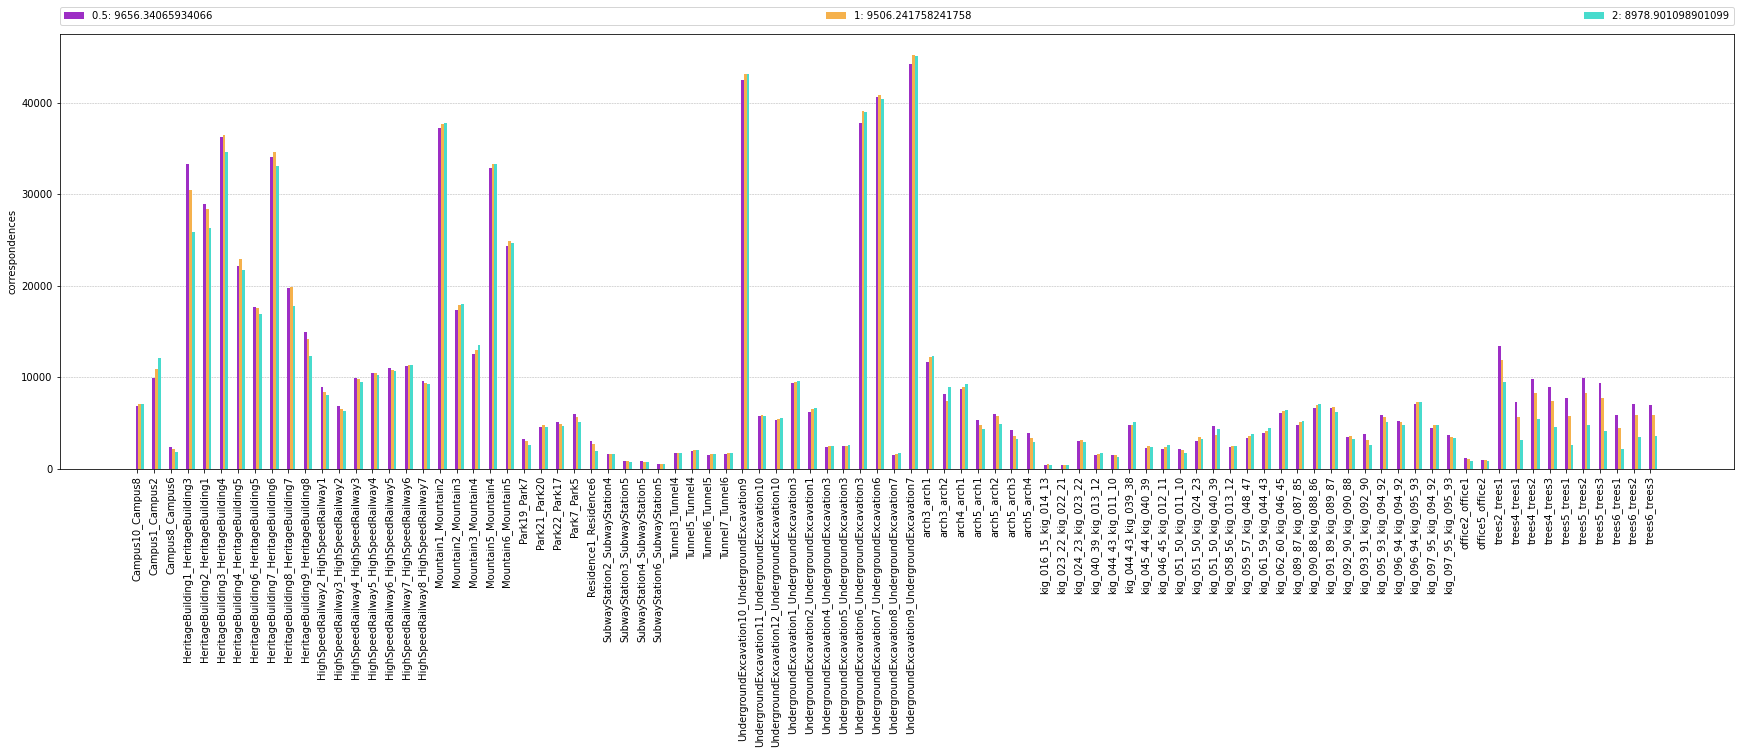

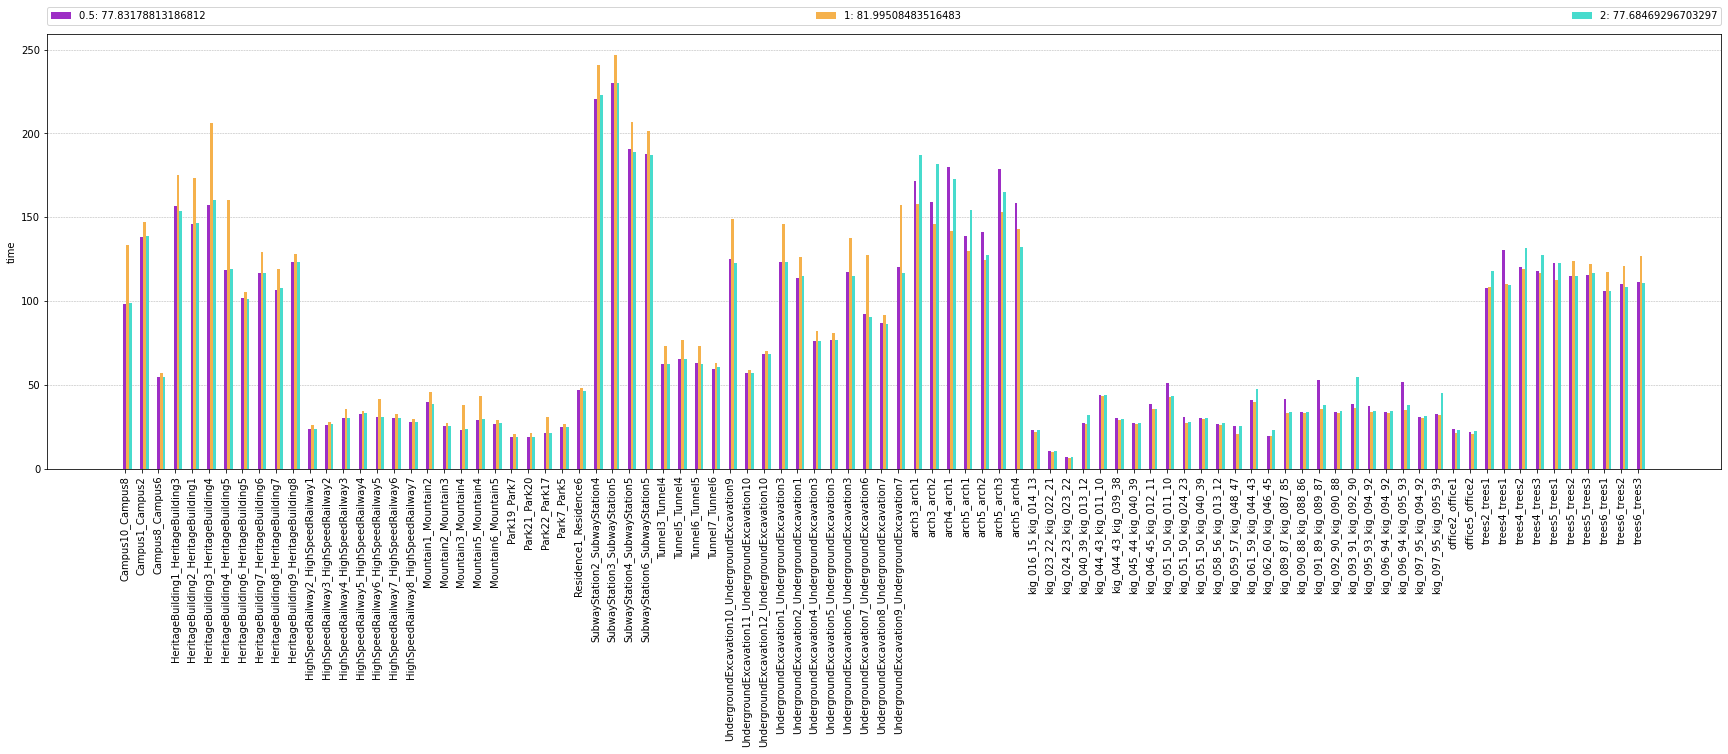

In [273]:
df = pd.read_csv('data/debug/test_results.csv')
df = df[(df['version'] == 15)]
df['ratio'] = df['distance_thr'] / df['iss_coef']
df['pcc'] = df['correct_correspondences'] / df['correspondences']
df['index'] = df.index
for keep in ['first']:
    df_filtered = df.sort_values(['testname', 'iss_coef']).drop_duplicates(['testname', 'distance_thr'], keep=keep)
#     df_filtered = df_filtered[['testname', 'distance_thr', 'iss_coef']]
#     display_colored(df_filtered, ['distance_thr', 'iss_coef'])
    radii = np.unique(df_filtered['iss_coef'].values)
    print(f'iss radii: {radii}')
#     display_colored(df_filtered, ['distance_thr', 'iss_coef'])
    analyze_by(df_filtered, 'ratio', [0.5, 1, 2], analyzed_parameters=['pcc', 'overlap_rmse', 'correspondences', 'time'], descriptors=['shot'], ticks_rotation='vertical')
# df['pcc'] = df['correct_correspondences'] / df['correspondences']

# # df['pcc'] = np.minimum(df['pcc'], 0.075)
# df['correct_correspondences'] = np.minimum(df['correct_correspondences'], 1000)
# df['overlap_rmse'] = np.minimum(df['overlap_rmse'], 0.2)
# # df['time'] = np.minimum(pd.to_numeric(df['time']), 500)
# analyze_by(df, 'version', [11, 15], analyzed_parameters=['pcc', 'correct_correspondences', 'correspondences', 'overlap_rmse', 'time'], descriptors=['shot'], ticks_rotation='vertical')

### multi-scale vs fixed scale

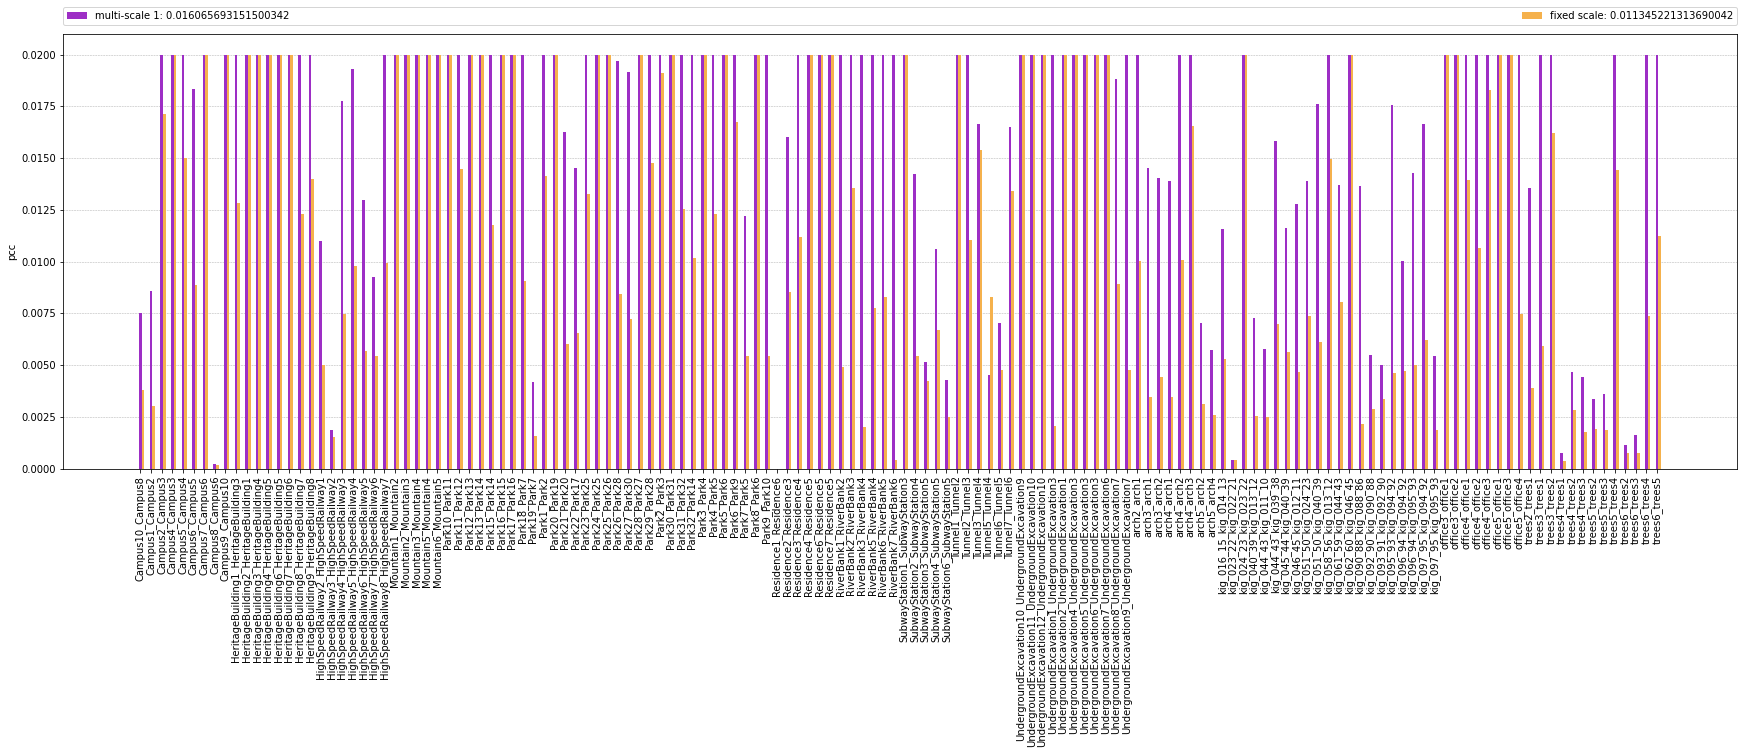

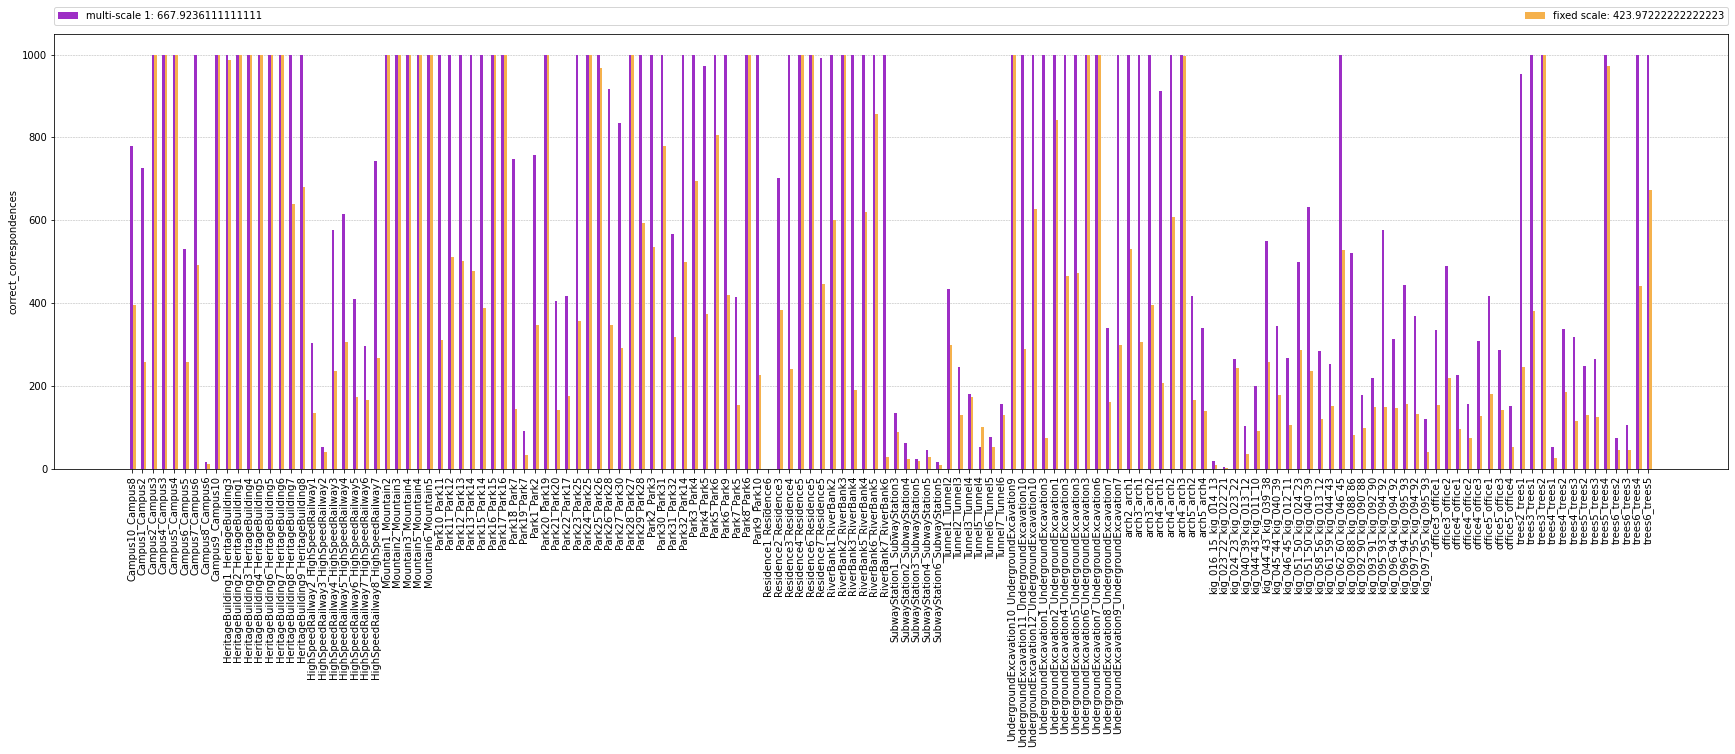

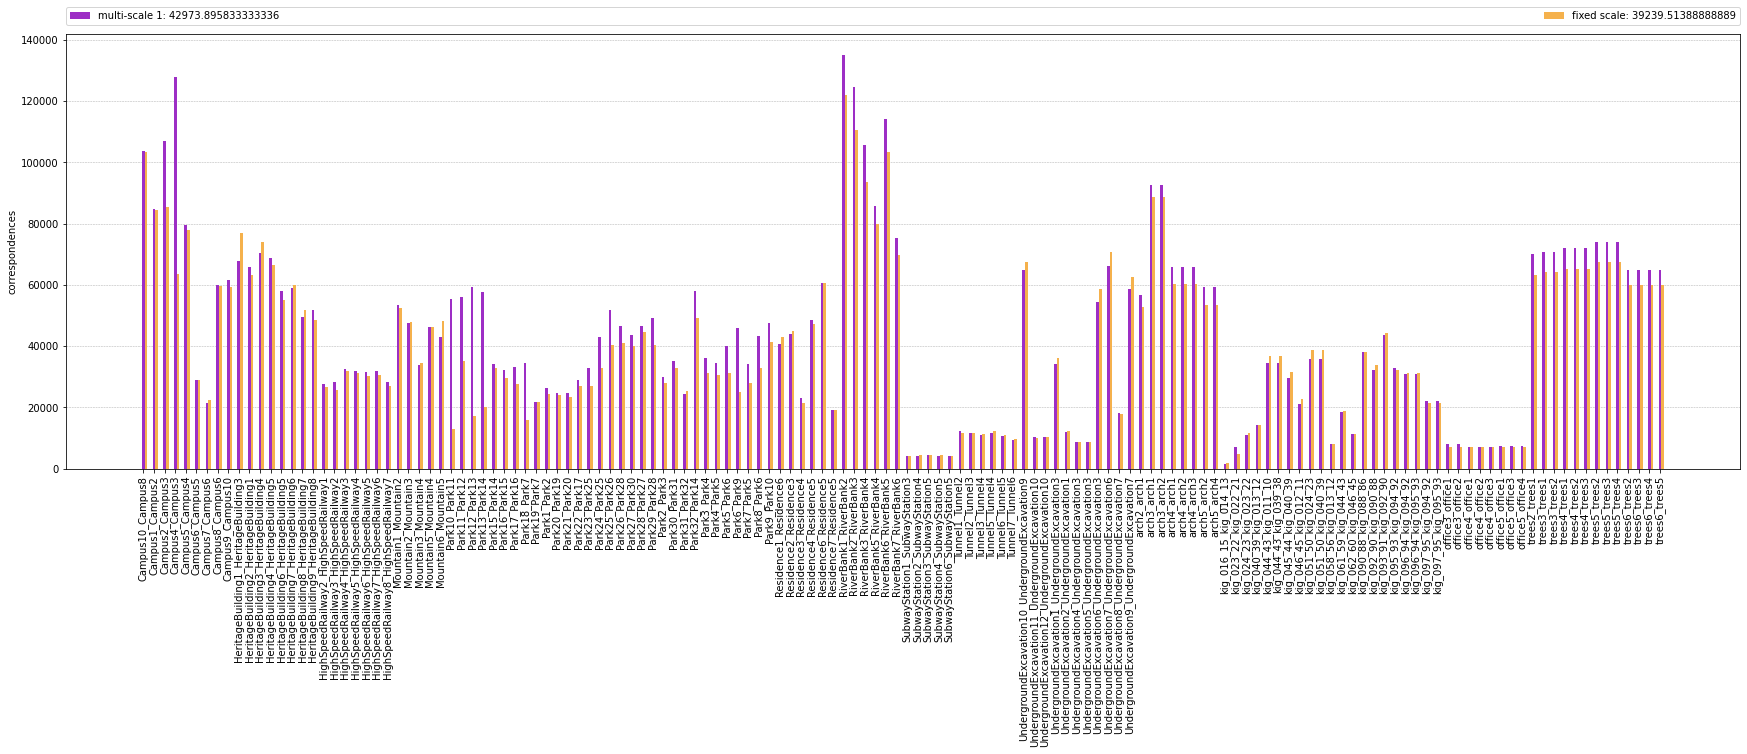

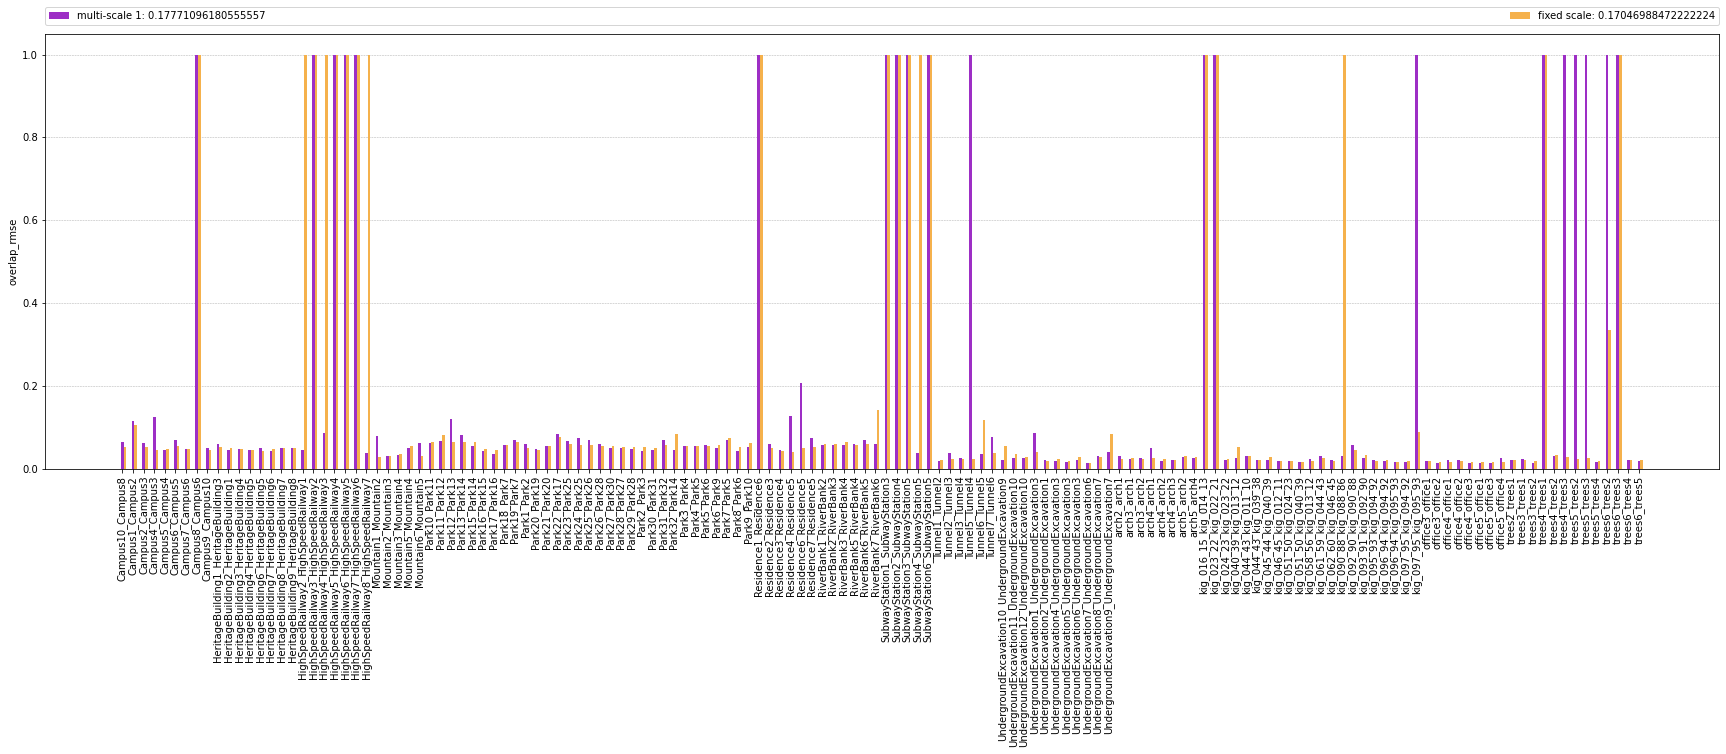

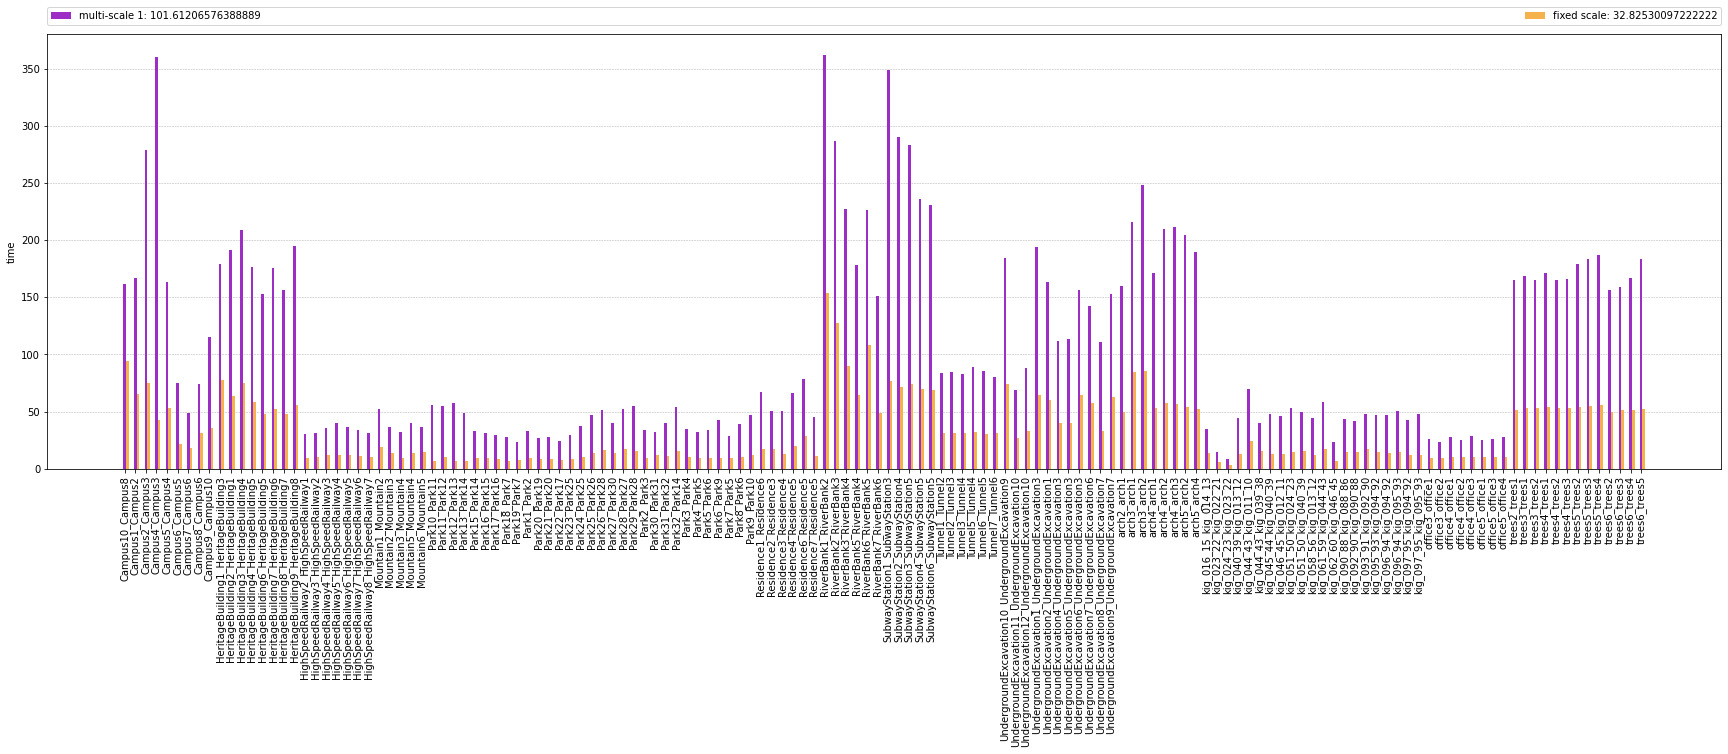

In [139]:
df = pd.read_csv('data/debug/test_results.csv')
df = df[(df['version'] == 13) | (df['version'] == 14)]
df['index'] = df.index
df['type'] = ''
df['type'] = df['type'].where(~((df['version'] == 14) & (df['reestimate'] == 1) & (df['normal_nr_points'] == 30) & (df['iss_coef'] == '1')), 'multi-scale 1')
df['type'] = df['type'].where(~((df['version'] == 14) & (df['reestimate'] == 1) & (df['normal_nr_points'] == 30) & (df['iss_coef'] == '0.25')), 'multi-scale 0.25')
df['type'] = df['type'].where(~((df['version'] == 13) & (df['index'] % 3 == 2)), 'fixed scale')
df['pcc'] = df['correct_correspondences'] / df['correspondences']
df['pcc'] = np.minimum(df['pcc'], 0.02)
df['correct_correspondences'] = np.minimum(df['correct_correspondences'], 1000)
df['overlap_rmse'] = np.minimum(df['overlap_rmse'], 1)
df['time'] = np.minimum(pd.to_numeric(df['time']), 500)
analyze_by(df, 'type', ['multi-scale 1', 'fixed scale'], analyzed_parameters=['pcc', 'correct_correspondences', 'correspondences', 'overlap_rmse', 'time'], descriptors=['shot'], ticks_rotation='vertical')

### scale factor

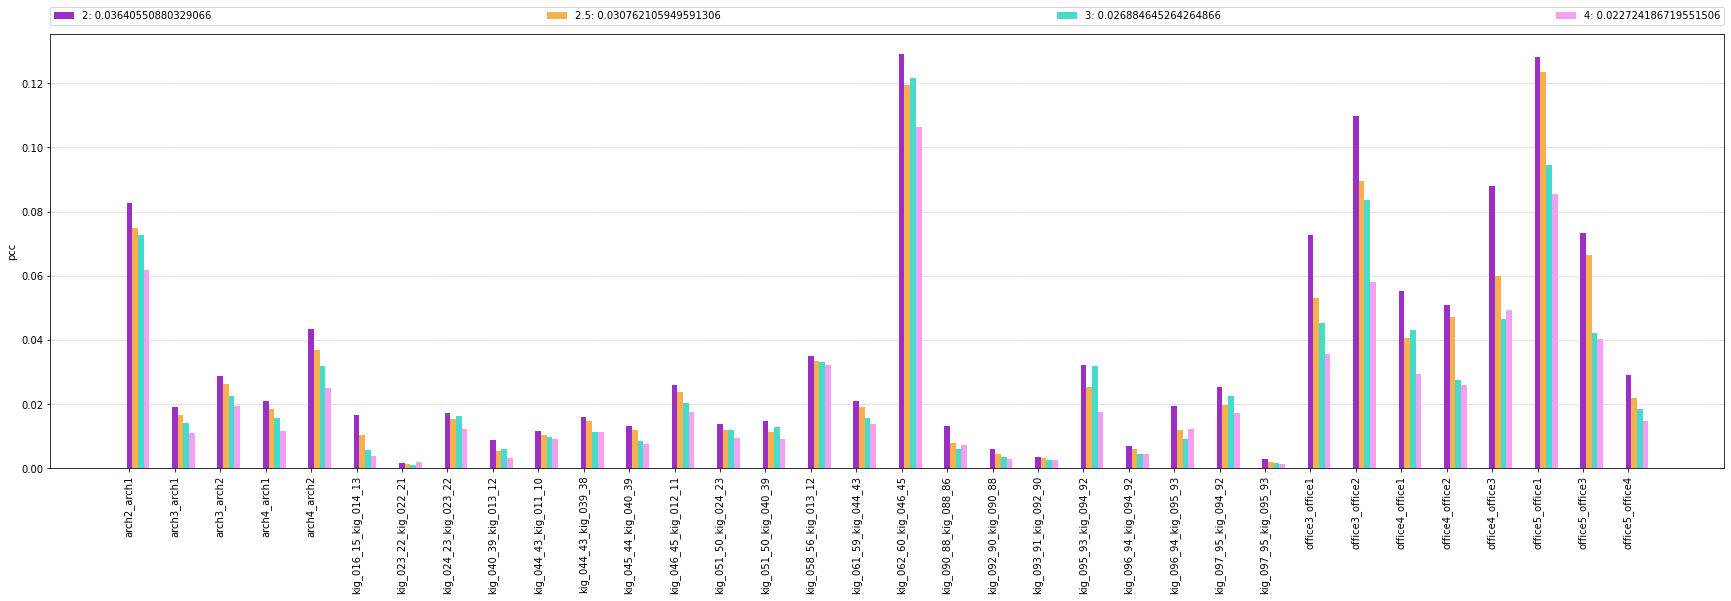

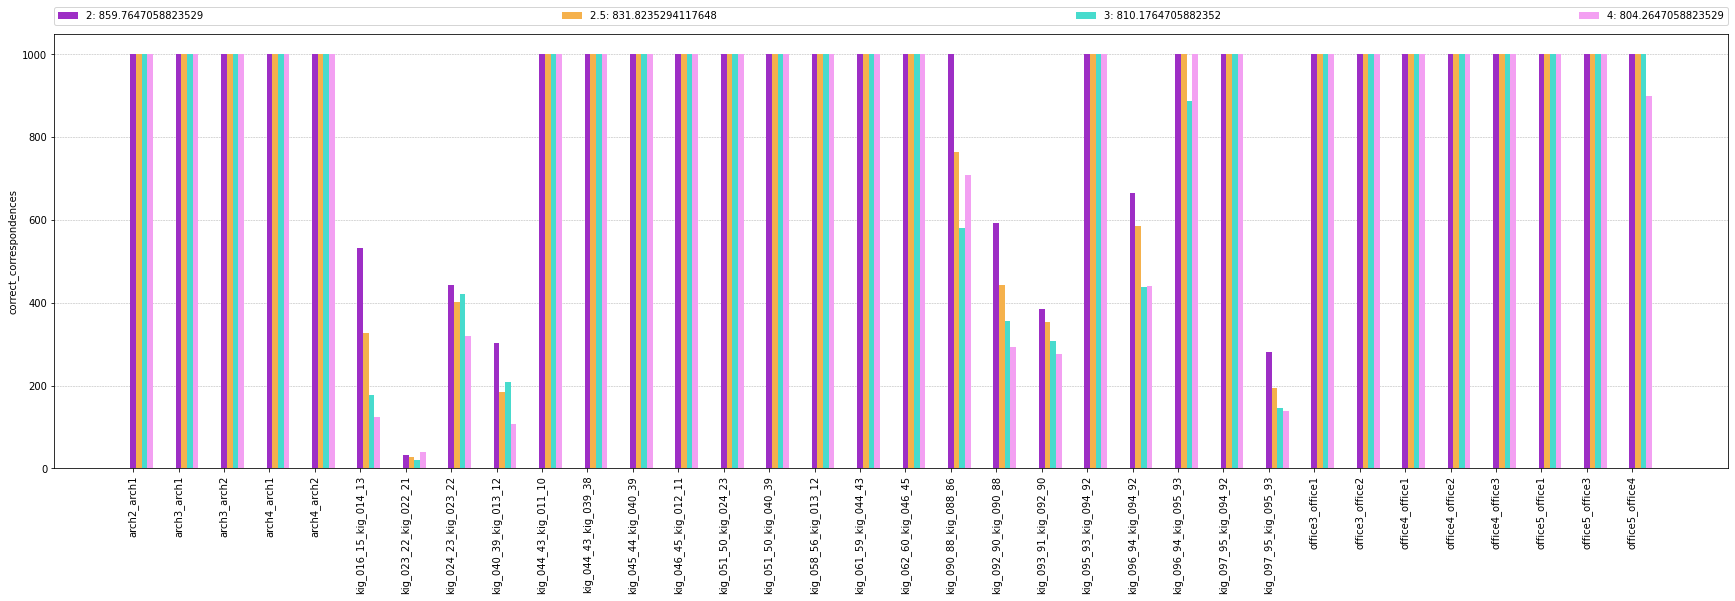

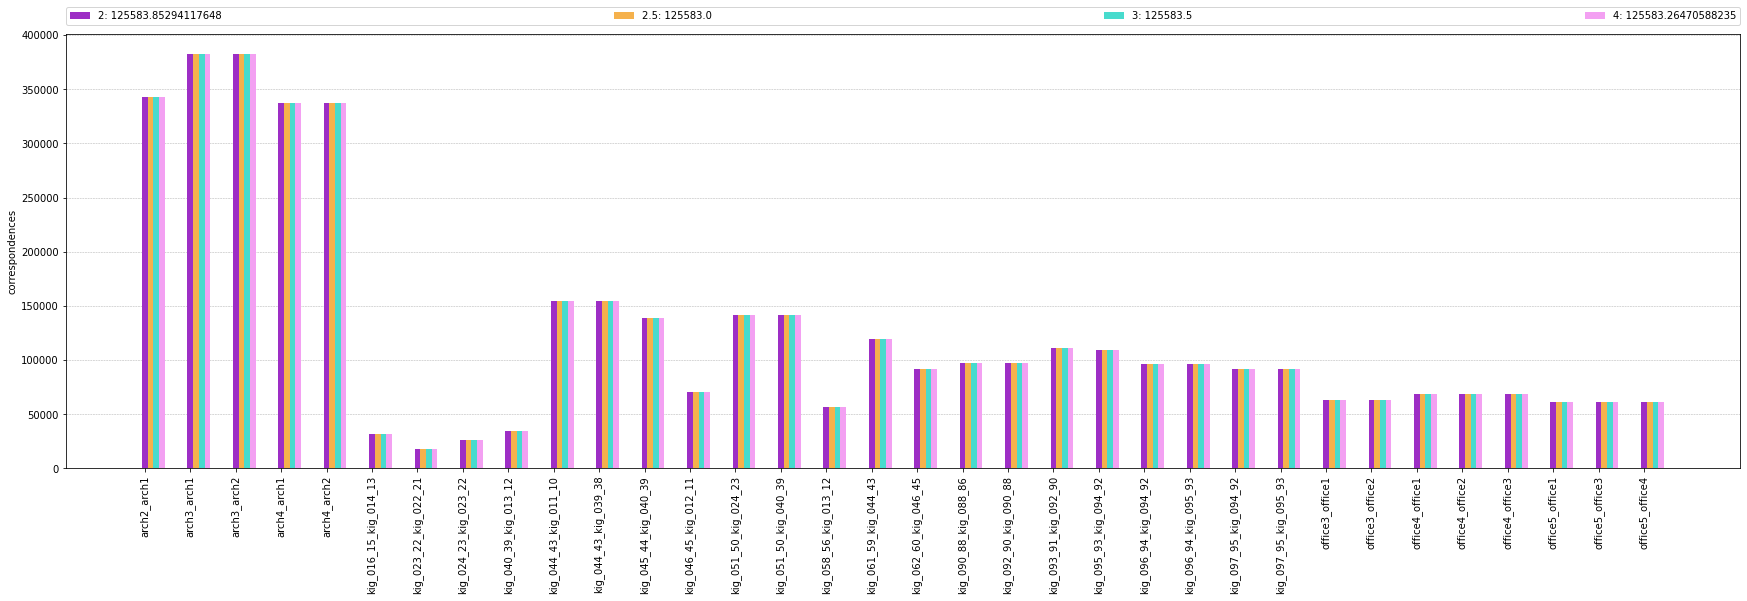

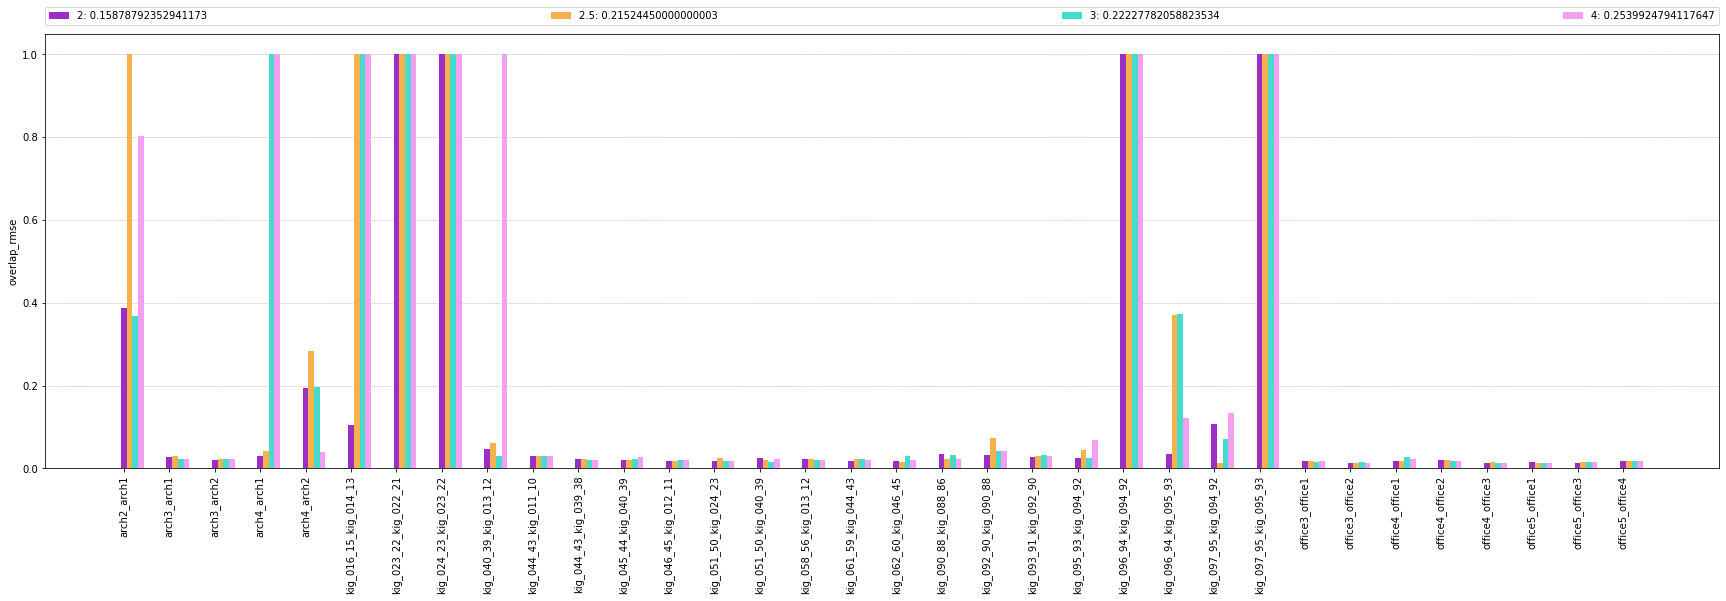

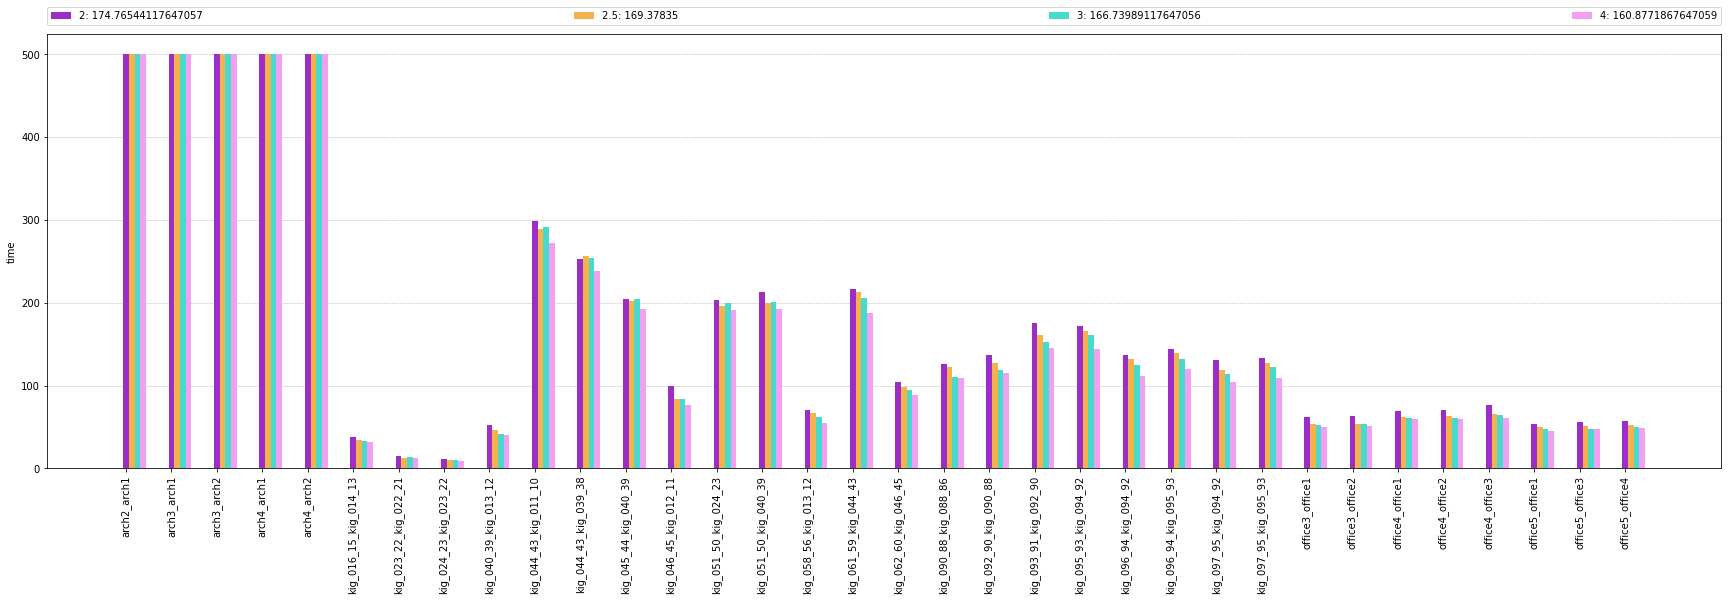

In [137]:
df = pd.read_csv('data/debug/test_results.csv')
df = df[df['version'] == '14_scales']
df['pcc'] = df['correct_correspondences'] / df['correspondences']
df['pcc'] = np.minimum(df['pcc'], 0.02)
df['correct_correspondences'] = np.minimum(df['correct_correspondences'], 1000)
df['overlap_rmse'] = np.minimum(df['overlap_rmse'], 1)
df['time'] = np.minimum(pd.to_numeric(df['time']), 500)
analyze_by(df, 'scale', [2, 2.5, 3, 4], analyzed_parameters=['pcc', 'correct_correspondences', 'correspondences', 'overlap_rmse', 'time'], descriptors=['shot'], ticks_rotation='vertical')

## Analyzing multi-scale matches

In [ ]:
from collections import defaultdict, namedtuple

DISTANCE_THR_COEF = 32

Match = namedtuple('Match', ['idx', 'dist', 'x', 'y', 'z', 'dist_l2'])

def choose_match(tokens: List[float], distance_thr: float, r: int = 1, equal: bool = False) -> float:
    matches = []
    best_dist_l2 = float('inf')
    for i in range(len(tokens) // 6):
        dist, x, y, z, dist_l2 = tokens[i * 6 + 2:i * 6 + 7]
        idx_match = int(tokens[i * 6 + 1])
        matches.append(Match(idx_match, dist, x, y, z, dist_l2))
        if dist_l2 > 0:
            best_dist_l2 = min(best_dist_l2, dist_l2)
    counter = []
    for i in range(len(matches) // r - 1):
        for k in range(r):
            reference = matches[r * i + k]
            count = [0, reference.dist]
            for j in range(i if not equal else 0, len(matches) // r):
                min_r2c_dist = float('inf')
                best_l = -1
                for l in range(r):
                    current = matches[r * j + l]
                    if current.idx < 0:
                        continue
                    r2c_dist = np.linalg.norm(np.array([reference.x - current.x, reference.y - current.y, reference.z - current.z]))
                    if r2c_dist < min_r2c_dist:
                        min_r2c_dist = r2c_dist
                        best_l = l
                if min_r2c_dist < DISTANCE_THR_COEF * distance_thr:
                    count[0] += distance_thr / max(min_r2c_dist, distance_thr)
                    
            counter.append(count)
    best_count = [0, 0.0]
    dist_l2 = float('inf')
    idx_match = -1
    for i, current_count in enumerate(counter):
        if best_count[0] < current_count[0] or best_count[0] == current_count[0] and best_count[1] > current_count[1]:
            best_count = current_count
            dist_l2 = matches[i].dist_l2
            idx_match = matches[i].idx
#     if dist_l2 > best_dist_l2 and best_dist_l2 < distance_thr:
#         print(f'chosen: {idx_match}')
#         for match in matches:
#             print(f'\t index: {match.idx}, [{match.x}, {match.y}, {match.z}], distance: {match.dist}, distance_l2: {match.dist_l2}')
    return dist_l2
        
df = pd.read_csv('data/debug/test_results.csv')
df = df[(df['version'] == 14) & (df['iss_coef'] == '0.25')]
testnames = df['testname'].values.flatten()
testnames = testnames[np.sort(np.unique(testnames, return_index=True)[1])]
testnames = ['kig_016_15_kig_014_13', 'kig_023_22_kig_022_21', 'HighSpeedRailway2_HighSpeedRailway1', 'trees6_trees3']

for testname in testnames:
    with open(f'data/debug/{testname}/{testname}_multiscale_352_shot_bf_gror_iss_gravity_ratio2_1_30_1_0.250000_14.csv', 'r') as file:
        lines = list(file.readlines())[1:]
        row = df[df['testname'] == testname]
        distance_thr = row['distance_thr'].values[0]
        curr_cc = row['correct_correspondences'].values[0]
        nr_levels = 0
        nr_matches = 0
        tokens_list = []
        for line in lines:
            tokens = list(map(float, line.split(',')))
            nr_levels = max(nr_levels, len(tokens) // 6)
            nr_matches += 1
            tokens_list.append(tokens)
        
        count_levels = np.zeros((nr_levels,), dtype=int)
        for i, tokens in enumerate(tokens_list):
            nr_levels_curr = len(tokens) // 6
            count_levels[nr_levels - nr_levels_curr:] += 1
        
        k_begin = 0
        while count_levels[k_begin] < count_levels[-1] / 3:
            k_begin += 1
        k_begin = 0
        k_end = 0
        print(count_levels)
        print(count_levels[k_begin: nr_levels - k_end])
        
        new_nr_levels = nr_levels - k_begin - k_end
        distances_l2 = np.full((nr_matches, new_nr_levels), float('inf'))
        distances_l2_chosen = np.full((nr_matches,), float('inf'))
        for i, tokens in enumerate(tqdm(tokens_list)):
            nr_levels_curr = len(tokens) // 6
            tokens = tokens[:1] + tokens[1 + 6 * max(0, k_begin - (nr_levels - nr_levels_curr)):]
            tokens = tokens[:1 + 6 * new_nr_levels]
#             for j in range(len(tokens) // 12):
#                 tokens = tokens[:-6 * (j + 2)] + tokens[-6 * (j + 1):]
            distances = np.array(tokens[6::6])
            distances[distances < 0] = float('inf')
            distances_l2[i, new_nr_levels - len(distances):] = distances            
            distances_l2_chosen[i] = choose_match(tokens, distance_thr)
        mask_cc = np.any(distances_l2 < distance_thr, axis=1)
        distances_l2_cc = distances_l2[mask_cc]
        max_cc = np.count_nonzero(mask_cc)
        print(f'[{testname}] maximum correct: {max_cc}/{nr_matches}, current correct: {curr_cc}/{nr_matches}, new correct: {np.count_nonzero(distances_l2_chosen < distance_thr)}/{nr_matches}')


In [ ]:
for testname in ['kig_023_22_kig_022_21', 'kig_016_15_kig_014_13', 'Campus8_Campus6', 'SubwayStation3_SubwayStation5']:
    df = pd.read_csv('data/debug/test_results.csv')
    df = df[df['testname'] == testname]
    df['pcc'] = df['correct_correspondences'] / df['correspondences']
    columns = ['version', 'testname', 'iss_coef', 'correct_correspondences', 'correspondences', 'pcc']
    df = df[columns].sort_values(['version', 'iss_coef'])
    display_colored(df, columns, cmap='YlGnBu', qmin=0.1, qmax=0.9, str_columns=['testname'])

### Analyzing difficult tests

In [ ]:
df = pd.read_csv('data/debug/test_results.csv')
df['pcc'] = df['correct_correspondences'] / df['correspondences']
df['pcc'] = np.minimum(df['pcc'].values.flatten(), 0.02)
df = df[df['iss_coef'] == '1']
analyze_by(df, by='version', methods=['14_levels_single_fixed', '14_levels_single_fixed_5'], analyzed_parameters=['pcc', 'correct_correspondences', 'correspondences', 'overlap_rmse', 'time'], descriptors=['shot'], ticks_rotation='vertical')

In [ ]:
plt.hist(corrs_max)
plt.show()

In [ ]:
df = pd.read_csv('data/debug/test_results.csv')
df['pcc'] = df['correct_correspondences'] / df['correspondences']
analyze_by(df, by='version', methods=['14_normals', '14_lrfs'], analyzed_parameters=['pcc', 'overlap_rmse', 'time'], descriptors=['shot'], ticks_rotation='vertical')

In [ ]:
angles_src = pd.read_csv('data/debug/arch3_wall_arch1_wall/arch3_wall_arch1_wall_angles_src_352_shot_bf_gror_iss_gravity_ratio2_1_14_normals.csv').values
angles_tgt = pd.read_csv('data/debug/arch3_wall_arch1_wall/arch3_wall_arch1_wall_angles_tgt_352_shot_bf_gror_iss_gravity_ratio2_1_14_normals.csv').values
plt.hist(angles_src, bins='rice')
plt.show()
plt.hist(angles_tgt, bins='rice')
plt.show()

In [ ]:
gt = pd.read_csv('data/usadba/ground_truth.csv')

t = np.linalg.inv(gt.iloc[0, 1:].values.reshape((4, 4)).astype(float))
for i in range(len(gt)):
    gt.iloc[i, 1:] = (t @ gt.iloc[i, 1:].values.reshape((4, 4)).astype(float)).flatten()
gt.to_csv('data/usadba/ground_truth.csv', index=False)

### Optimal number of points in descriptor

In [ ]:
# descriptor_size = 352
# data = []
# quantiles = [ 0.1, 0.3, 0.5, 0.7, 0.9 ]
# nrs_points = [ 352, 704, 1408, 2112, 2816, 3520 ]
# testnames = (['kig_016_15_kig_016_15', 'kig_016_15_kig_016_15_transformed_r_t'] + pd.read_csv('data/tests.csv').values.flatten().tolist())[53::4]
# titles = ['corresponding', 'closest(source)', 'ratio(source)', 'closest(target)', 'ratio(target)', 'random(target)']
# for test in tqdm(testnames):
#     for nr_points in nrs_points:
#         hists_src = pd.read_csv(f'data/debug/{test}/{test}_histograms_src_shot_bf_15000_default_iss_gravity_cluster_1_12_{nr_points}.csv', header=None, usecols=np.arange(descriptor_size + 1).tolist())
#         hists_tgt = pd.read_csv(f'data/debug/{test}/{test}_histograms_tgt_shot_bf_15000_default_iss_gravity_cluster_1_12_{nr_points}.csv', header=None, usecols=np.arange(descriptor_size + 1).tolist())
#         hists_src = hists_src.drop(columns=[0]).values.astype(float)
#         hists_tgt = hists_tgt.drop(columns=[0]).values.astype(float)
#         np.nan_to_num(hists_src, copy=False)
#         np.nan_to_num(hists_tgt, copy=False)
#         N = len(hists_src)

#         corresponding_dists = np.linalg.norm(hists_src - hists_tgt, axis=1)
        
#         closest_dists_src = pd.read_csv(f'data/debug/{test}/{test}_closest_dists_src_shot_bf_15000_default_iss_gravity_cluster_1_12_{nr_points}.csv').values
#         closest_dists_tgt = pd.read_csv(f'data/debug/{test}/{test}_closest_dists_tgt_shot_bf_15000_default_iss_gravity_cluster_1_12_{nr_points}.csv').values
#         np.nan_to_num(closest_dists_src, copy=False)
#         np.nan_to_num(closest_dists_tgt, copy=False)
        
#         closest_dists_src_ratio = corresponding_dists / np.maximum(closest_dists_src, 1e-9)
#         closest_dists_tgt_ratio = corresponding_dists / np.maximum(closest_dists_tgt, 1e-9)
#         random_dists_tgt = np.array([np.linalg.norm(hists_src[i] - hists_tgt[np.random.randint(0, N)]) for i in range(N)[::50]])
#         row = [test, nr_points]
#         for dists in [corresponding_dists, closest_dists_src, closest_dists_src_ratio, closest_dists_tgt, closest_dists_tgt_ratio, random_dists_tgt]:
#             row += np.quantile(dists, quantiles).tolist()
#             row.append(np.mean(dists))
#         data.append(row)
# columns = ['testname', 'nr_points']
# for title in titles:
#     for q in quantiles:
#         columns.append(f'{title}_{q}')
#     columns.append(f'{title}_mean')
# df_nr_points = pd.DataFrame(data, columns=columns)
# df_nr_points['descriptor'] = 'shot'

In [ ]:
# display_colored(df_nr_points, columns[1:], cmap='YlGnBu', qmin=0.0, qmax=1.0, str_columns=['testname'])
df_nr_points = pd.read_csv('data/nr_points.csv')
analyze_by(df_nr_points, by='nr_points',  methods=nrs_points, analyzed_parameters=['corresponding_0.1', 'corresponding_0.5', 'ratio(target)_0.1', 'ratio(target)_0.3', 'random(target)_0.1'],
           descriptors=['shot'], ticks_rotation='vertical')

In [ ]:
from collections import defaultdict
test = 'Mountain1_Mountain2'
fr = 15000
dists_list = []
corrs = []
corrs_max = []
with open(f'data/debug/{test}/{test}_multiscale_352_shot_bf_{fr}_gror_iss_gravity_ratio2_2_13.csv', 'r') as file:
    for line in file.readlines()[1:]:
        tokens = line.split(',')
        d = defaultdict(list)
        for i in range(len(tokens) // 3):
            index_match = int(tokens[i * 3 + 1])
            if index_match != -1:
                d[index_match].append((float(tokens[i * 3 + 2]), float(tokens[i * 3 + 3])))
        corrs.append(d)
        corrs_max.append(max([len(v) for v in d.values()]))

In [ ]:
len(corrs_max)

In [ ]:
plt.hist(corrs_max, bins='rice')
plt.show()

In [ ]:
df = pd.read_csv('data/debug/test_results.csv')
df['pcc'] = df['correct_correspondences'] / df['correspondences']
df['type'] = '11'
df['overlap_rmse'] = np.minimum(df['overlap_rmse'].values.astype(float), 0.2)
testnames = np.unique(df['testname'].values)
for nr in [352, 704, 3520]:
    df['type'] = df['type'].where(~((df['version'] == 12) & (df['nr_points'] == nr)), f'12_{nr}')
df['idx'] = df.index
df['type'] = df['type'].where(~((df['version'] == 13) & (df['idx'] % 3 == 1)), '13_small')
df['type'] = df['type'].where(~((df['version'] == 13) & (df['idx'] % 3 == 2)), '13_middle')
df['type'] = df['type'].where(~((df['version'] == 13) & (df['idx'] % 3 == 0)), '13_big')
df['type'] = df['type'].where(~(df['version'] == 14), '14')
# df['type'] = df['type'].where(~(df['version'] == 16), f'16')
df = df[df['testname'].isin(testnames)]
analyze_by(df, by='type', methods=['13_small', '13_middle', '13_big', '14'], analyzed_parameters=['pcc', 'overlap_rmse'], descriptors=['shot'], ticks_rotation='vertical')
# df = df[['version', 'testname', 'pcc', 'correspondences', 'correct_correspondences', 'inliers', 't_err', 'r_err', 'overlap_rmse']]
# display_colored(df.sort_values(['testname', 'version']), columns, cmap='YlGnBu', qmin=0.1, qmax=0.9, str_columns=['testname'])

In [ ]:
# df = pd.read_csv('data/debug/test_results.csv')
# df['pcc'] = df['correct_correspondences'] / df['correspondences']
# df = df[['testname', 'correspondences', 'correct_correspondences', 'inliers', 'correct_inliers', 'pcc', 'feature_radius', 'overlap_rmse']]
# df['idx'] = df.index
# columns = ['correspondences', 'correct_correspondences', 'inliers', 'correct_inliers', 'pcc', 'feature_radius', 'overlap_rmse']
# display_colored(df.sort_values(['testname', 'feature_radius']), columns, cmap='YlGnBu', qmin=0.1, qmax=0.9, str_columns=['testname'])

In [ ]:
# N = 50
# seed = 566
# descriptor_size = 352

# # np.random.seed(seed)
# # random_correct = np.argwhere(is_correct)[np.random.randint(0, count_correct, N)].flatten()
# # random_incorrect = np.argwhere(~is_correct)[np.random.randint(0, count_incorrect, N)].flatten()
# # random_all = np.hstack((random_correct, random_incorrect))
# # print(random_all)

# # for vs_ds in [1, 50, 75, 100, 150, 200, 500, 1000]:
# #     analyze_descriptors(f'data/debug/kig_023_22_roof_kig_022_21_roof/kig_023_22_roof_kig_022_21_roof_histograms_src_500_shot_bf_3_5_default_iss_gravity_cluster_1_1_11.csv',
# #                         f'data/debug/kig_023_22_roof_kig_022_21_roof/kig_023_22_roof_kig_022_21_roof_histograms_src_500_shot_bf_3_5_default_iss_gravity_cluster_1_{vs_ds}_11.csv',
# #                         random_all, random_all,
# #                         descriptor_size=352,
# #                         confusion_matrix_fn=l2_confusion_matrix)
# for test in ['kig_023_22_kig_022_21', 'kig_058_56_kig_013_12']:
#     for pcd in ['src', 'tgt']:
#         reference = pd.read_csv(f'data/debug/{test}/{test}_histograms_{pcd}_500_shot_bf_3_5_default_iss_gravity_cluster_1_1_11.csv', header=None, usecols=np.arange(descriptor_size + 1).tolist())
#         reference.drop(columns=[0], inplace=True)
#     #     reference = reference[:20]
#     #     _, unique_indices = np.unique(reference.values, return_index=True, axis=0)
#     #     reference = reference.values[unique_indices]
#         for i, vs_ds in enumerate([1, 10, 50, 100, 200]):
#             hists = pd.read_csv(f'data/debug/{test}/{test}_histograms_{pcd}_500_shot_bf_3_5_default_iss_gravity_cluster_1_{vs_ds}_11.csv', header=None, usecols=np.arange(descriptor_size + 1).tolist())
#             hists.drop(columns=[0], inplace=True)
#     #         hists = hists[:20]
#             volumes = pd.read_csv(f'data/debug/{test}/{test}_volumes_500_shot_bf_3_5_default_iss_gravity_cluster_1_{vs_ds}_11.csv', header=None, usecols=np.arange(32).tolist()).values
#     #         volumes = volumes[:40]
#             if pcd == 'src':
#                 volumes = volumes[:len(volumes) // 2]
#             else:
#                 volumes = volumes[len(volumes) // 2:]
#             dists1 = np.zeros(len(reference) // N)
#             dists2 = np.zeros(len(reference) // N)
#     #         show_confusion_matrix(l2_confusion_matrix(reference.values, hists.values))
#             for j in tqdm(range(len(reference) // N)):
#                 idx = j * N + N - 1
#                 dists = l2_confusion_matrix(reference.values[idx:idx + 1], hists.values).flatten()
#                 dists1[j] = dists[idx]
#                 dists2[j] = np.partition(dists, 1)[1]
#             dists2 = np.where(dists2 == 0, 1, dists2)
#             ratio = dists1 / dists2
#             xs = 0.2 + 0.8 * np.arange(40) / 40
#             ys = [np.count_nonzero(ratio < x) / len(ratio) for x in xs]
#             plt.plot(xs, ys, label=f'voxel size = {vs_ds}')

#             mask = ratio < 0.95
#             print(f'voxel size = {vs_ds}: # points in histogram = {np.quantile(np.median(volumes[N - 1::N][mask], axis=1), [0.1, 0.3, 0.5, 0.7, 0.9])},'
#                   f'# points in descriptor = {np.quantile(np.sum(volumes[N - 1::N][mask], axis=1), [0.1, 0.3, 0.5, 0.7, 0.9])}')
#         plt.legend()
#         plt.show()
        


In [ ]:
df = pd.read_csv('distances.csv')
voxel_size = 0.0078332
dists = df.values
xs = np.arange(80) / 20
ys = [np.count_nonzero(dists < x * voxel_size) / len(dists) for x in xs]
plt.plot(xs, ys)

In [ ]:
# show_uniquenesses('data/debug/KilwaKisiwani_40r_KilwaKisiwani_43r_uniquenesses_src_random_01.csv')
# show_uniquenesses('data/debug/Hokuyo_4_Hokuyo_8_uniquenesses_src_random_01.csv')
# show_uniquenesses('data/debug/bun000_bun045_uniquenesses_src_random_01.csv')

In [ ]:
# df = pd.read_csv('data/debug/test_metrics.csv')
# df = df[['testname', 'metric_corr', 'metric_corr_gt', 'metric_icp', 'metric_icp_gt']]
# df['combination'] = df['metric_corr'] * df['metric_icp']
# df['combination_gt'] = df['metric_corr_gt'] * df['metric_icp_gt']
# df['testname'] = df.testname.apply(lambda s: s[5:7] + '-' + s[16:18])
# display(df.style.background_gradient(subset=['metric_corr', 'metric_icp', 'metric_corr_gt', 'metric_icp_gt', 'combination', 'combination_gt']))
# latex_table = df.to_latex(float_format="%.3f", index=False)
# print(latex_table)

In [ ]:
columns = ['version', 'descriptor','testname', 'use_normals', 'rmse','r_err','t_err','pcd_err', 'normal_diff','voxel_size','normal_radius_coef','feature_radius','pcc', 'correct_correspondences', 'correspondences', 'inliers', 'correct_inliers','filter','threshold','n_random', 'corr_uniformity', 'overlap_rmse']

In [ ]:
# df = pd.read_csv('data/debug/test_results.csv')
# df['pcc'] = df['correct_correspondences'] / df['correspondences']
# display_colored(df, columns)

In [ ]:
def analyze_lrfs(df, parameters, descriptors=['shot', 'rops'], lrf_types=['default', 'gt', 'gravity'], ticks_rotation='horizontal'):
    for desc in descriptors:
        df_desc = df[df['descriptor'] == desc]
        testnames = list(sorted(reduce(np.intersect1d, [df_desc[df_desc['lrf'] == lrf]['testname'].values for lrf in lrf_types])))
        df_desc = df_desc[df_desc['testname'].isin(testnames)]
        df_desc = df_desc.sort_values('testname')
        n, m = len(lrf_types), len(testnames)
        if m == 0:
            continue
        for p in parameters:
            hists = np.zeros((n, m))
            tick_labels = []
            for i, lrf in enumerate(lrf_types):
                for j, testname in enumerate(testnames):
                    hists[i, j] = df_desc[(df_desc['testname'] == testname) & (df_desc['lrf'] == lrf)][p].values[0]     
            show_bar_plots(hists, testnames, lrf_types, empty=0.5, ticks_rotation=ticks_rotation, ylabel=p)

In [ ]:
# df = pd.read_csv('data/debug/test_results.csv')
# df['testname'] = df['testname'] + '_' + df['voxel_size'].astype(str)
# df['pcc'] = df['correct_correspondences'] / df['correspondences']
# df = df[(df['descriptor'] != 'fpfh') & (df['version'] == '03')]
# df['lrf'] = df['lrf'].fillna('default')

# parameters = ['pcc']
# for pname in parameters:
#     d = {desc + t: p for desc, t, p in df[df['lrf'] == 'default'][['descriptor', 'testname', pname]].values}
#     df['default'] = (df['descriptor'] + df['testname']).apply(lambda t: d[t])
#     df['relative_' + pname] = df[pname] / df['default']
# analyze_lrfs(df, ['relative_' + pname for pname in parameters] + ['correct_correspondences'], ticks_rotation='vertical')
# df = df[['version', 'testname', 'descriptor', 'lrf', 'pcc', 'correspondences', 'correct_correspondences', 'inliers', 'pcd_err', 't_err', 'r_err']]
# display_colored(df.sort_values(['testname', 'descriptor']), columns)

In [ ]:
# df = pd.read_csv('data/debug/test_results_office.csv')
# df['testname'] = df['testname'] + '_' + df['voxel_size'].astype(str)
# df['pcc'] = df['correct_correspondences'] / df['correspondences']
# df = df[df['descriptor'] != 'fpfh']
# df['lrf'] = df['lrf'].fillna('default')

# parameters = ['pcc']
# for pname in parameters:
#     d = {desc + t: p for desc, t, p in df[df['lrf'] == 'default'][['descriptor', 'testname', pname]].values}
#     df['default'] = (df['descriptor'] + df['testname']).apply(lambda t: d[t])
#     df['relative_' + pname] = df[pname] / df['default']
# analyze_lrfs(df, ['relative_' + pname for pname in parameters] + ['correct_correspondences'], ticks_rotation='vertical')
# df = df[['version', 'testname', 'descriptor', 'lrf', 'pcc', 'correspondences', 'correct_correspondences', 'inliers', 'pcd_err', 't_err', 'r_err']]
# display_colored(df.sort_values(['testname', 'descriptor']), columns)

### FPFH

In [ ]:
# df = pd.read_csv('data/debug/fpfh_results_02.csv')
# df['pcc'] = df['correct_correspondences'] / df['correspondences']
# df_bun = df[df['testname'] == "bun000_bun045"][columns]
# df_hokuyo = df[df['testname'] == 'Hokuyo_4_Hokuyo_8'][columns]

In [ ]:
# display_colored(df_bun.sort_values('pcd_err'), columns)

In [ ]:
# display_colored(df_hokuyo.sort_values('pcd_err'),columns)

### SHOT

In [ ]:
# df = pd.read_csv('data/debug/shot_results_02.csv')
# df['pcc'] = df['correct_correspondences'] / df['correspondences']
# df_bun = df[df['testname'] == "bun000_bun045"][columns]
# df_hokuyo = df[df['testname'] == 'Hokuyo_4_Hokuyo_8'][columns]

In [ ]:
# display_colored(df_bun.sort_values('pcd_err'), columns)

In [ ]:
# display_colored(df_hokuyo.sort_values('pcd_err'), columns)

### RoPS

In [ ]:
# df = pd.read_csv('data/debug/rops_results_02.csv')
# df['pcc'] = df['correct_correspondences'] / df['correspondences']
# df_bun = df[df['testname'] == "bun000_bun045"][columns]
# df_hokuyo = df[df['testname'] == 'Hokuyo_4_Hokuyo_8'][columns]

In [ ]:
# display_colored(df_bun.sort_values('pcd_err'), columns)

In [ ]:
# display_colored(df_hokuyo.sort_values('pcd_err'), columns)

### With normals

In [ ]:
def with_normals(testname):
    df = pd.read_csv('data/debug/test_results.csv')
    df['pcc'] = df['correct_correspondences'] / df['correspondences']
    df = df[df['testname'] == testname][columns]
    df.loc[df['use_normals'] == 1, 'version'] = '02_normals'
    df = df[df['voxel_size'] == 0.05]
    df = df[['version', 'testname', 'descriptor','pcc', 'use_normals', 'normal_diff', 'normal_radius_coef', 'correct_correspondences', 'correspondences', 'correct_inliers', 'inliers']]
    df = df.sort_values(by=['descriptor', 'normal_radius_coef', 'use_normals'])
    display_colored(df, columns)
    plot_line_graph(df, 'normal_radius_coef', 'correct_correspondences', ['02', '02_surface', '02_normals'], descriptors=['shot'])
    plot_line_graph(df, 'normal_radius_coef', 'correct_correspondences', ['02', '02_surface', '02_normals'], descriptors=['fpfh'])

In [ ]:
# with_normals('kig_058_56_overlap_kig_013_12_overlap')

In [ ]:
# with_normals('kig_077_75_kig_076_74')

In [ ]:
def normal_difference(testname, pcd_type):
    plt.rcParams["figure.figsize"] = (8, 6)
    df = pd.read_csv(f'data/debug/{testname}_normal_difference_{pcd_type}.csv')
    df = df.drop_duplicates()
    df_columns = [c for c in df.columns if c not in ['smoothing']]
    show_confusion_matrix(df[df_columns], labels1=df_columns, labels2=df['smoothing'], vmax=0.35)
    plt.rcParams["figure.figsize"] = (8, 6)

In [ ]:
# normal_difference('kig_058_56_overlap_kig_013_12_overlap', 'src')
# normal_difference('kig_058_56_overlap_kig_013_12_overlap', 'tgt')

In [ ]:
# normal_difference('kig_077_75_kig_076_74', 'src')
# normal_difference('kig_077_75_kig_076_74', 'tgt')

In [ ]:
# paths = ['data/debug/Hokuyo_4_Hokuyo_8_correspondences_debug_600_fpfh_flann_4_10_default_correspondences_ratio_1_05_prc.csv',
#          'data/debug/Hokuyo_4_Hokuyo_8_correspondences_debug_600_shot_flann_4_10_default_correspondences_ratio_1_05_prc.csv',
#          'data/debug/kig_058_56_kig_013_12_correspondences_debug_500_fpfh_bf_4_15_default_correspondences_ratio_1_05_prc.csv',
#          'data/debug/kig_058_56_kig_013_12_correspondences_debug_500_shot_bf_4_15_default_correspondences_ratio_1_05_prc.csv']
# names = ['Hokuyo_fpfh', 'Hokuyo_shot', 'kig_fpfh', 'kig_shot']
# build_prc(paths, names, thrs=[0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1.0])

In [ ]:
# paths = ['data/debug/bun000_bun045_correspondences_debug_8_fpfh_flann_4_10_default_correspondences_cluster_1_05_prc.csv']
# names = ['bun_fpfh']
# build_prc(paths, names, thrs=np.arange(12) / 12 * 0.4 + 0.6, reverse=True)

In [ ]:
# paths = ['data/debug/kig_023_22_kig_024_23_correspondences_debug_500_shot_bf_3_15_default_correspondences_ratio_1_06.csv',
#          'data/debug/kig_023_22_kig_024_23_correspondences_debug_500_shot_bf_3_15_default_correspondences_cluster_1_06.csv']
# names = ['24_ratio_shot', '24_cluster_shot']
# build_prc(paths, names, thrs=np.arange(1, 21) / 20 * 1.0 + 0.0)
# paths = ['data/debug/kig_096_94_kig_094_92_correspondences_debug_500_shot_bf_3_15_default_correspondences_ratio_1_06.csv',
#          'data/debug/kig_096_94_kig_094_92_correspondences_debug_500_shot_bf_3_15_default_correspondences_cluster_1_06.csv']
# names = ['96_ratio_shot', '96_cluster_shot']
# build_prc(paths, names, thrs=np.arange(1, 21) / 20 * 1.0 + 0.0)

In [ ]:
# paths = ['data/debug/kig_058_56_kig_013_12_correspondences_debug_500_fpfh_bf_4_15_default_correspondences_cluster_1_05_prc.csv',
#          'data/debug/kig_058_56_kig_013_12_correspondences_debug_500_shot_bf_4_15_default_correspondences_cluster_1_05_prc.csv']
# names = ['kig_fpfh', 'kig_shot']
# build_prc(paths, names, thrs=np.arange(20) / 20 * 0.8 + 0.2, reverse=True)

In [ ]:
# paths = ['data/debug/Hokuyo_4_Hokuyo_8_correspondences_debug_600_fpfh_flann_4_10_default_correspondences_cluster_2_05_prc.csv',
#          'data/debug/Hokuyo_4_Hokuyo_8_correspondences_debug_600_shot_flann_4_10_default_correspondences_cluster_2_05_prc.csv']
# names = ['Hokuyo_fpfh', 'Hokuyo_shot']
# build_prc(paths, names, thrs=np.arange(20) / 20 * 0.8 + 0.2)
# paths = ['data/debug/kig_058_56_kig_013_12_correspondences_debug_500_fpfh_bf_4_15_default_correspondences_cluster_2_05_prc.csv',
#          'data/debug/kig_058_56_kig_013_12_correspondences_debug_500_shot_bf_4_15_default_correspondences_cluster_2_05_prc.csv']
# names = ['kig_fpfh', 'kig_shot']
# build_prc(paths, names, thrs=np.arange(20) / 20 * 0.8 + 0.2)

In [ ]:
# paths = ['data/debug/Hokuyo_4_Hokuyo_8_correspondences_debug_600_fpfh_flann_4_10_default_correspondences_cluster_1_05_prc.csv',
#          'data/debug/Hokuyo_4_Hokuyo_8_correspondences_debug_600_shot_flann_4_10_default_correspondences_cluster_1_05_prc.csv',
#          'data/debug/kig_058_56_kig_013_12_correspondences_debug_500_fpfh_bf_4_15_default_correspondences_cluster_1_05_prc.csv',
#          'data/debug/kig_058_56_kig_013_12_correspondences_debug_500_shot_bf_4_15_default_correspondences_cluster_1_05_prc.csv']
# names = ['Hokuyo_fpfh', 'Hokuyo_shot', 'kig_fpfh', 'kig_shot']
# build_prc(paths, names, thrs=np.arange(20) / 20 * 0.8 + 0.2, reverse=True)

In [ ]:
# paths = ['data/debug/Hokuyo_4_Hokuyo_8_correspondences_debug_600_fpfh_flann_4_10_default_correspondences_cluster_2_05_prc.csv',
#          'data/debug/Hokuyo_4_Hokuyo_8_correspondences_debug_600_shot_flann_4_10_default_correspondences_cluster_2_05_prc.csv',
#          'data/debug/kig_058_56_kig_013_12_correspondences_debug_500_fpfh_bf_4_15_default_correspondences_cluster_2_05_prc.csv',
#          'data/debug/kig_058_56_kig_013_12_correspondences_debug_500_shot_bf_4_15_default_correspondences_cluster_2_05_prc.csv']
# names = ['Hokuyo_fpfh', 'Hokuyo_shot', 'kig_fpfh', 'kig_shot']
# build_prc(paths, names, thrs=np.arange(20) / 20 * 0.8 + 0.2)

### Weights

In [ ]:
# import os
# import matplotlib.colors as mcolors

# PATH = os.path.join('data', 'debug')
# COLORS = list(mcolors.BASE_COLORS.keys())

# def analyze_weights(testnames, parameters):
#     inliers, inliers_gt, curvatures = [], [], []
#     for i, (testname, ps) in enumerate(zip(testnames, parameters)):
#         inliers.append(pd.read_csv(os.path.join(PATH, testname + '_inliers_' + ps + '.csv')).values.flatten())
#         inliers_gt.append(pd.read_csv(os.path.join(PATH, testname + '_inliers_gt_' + ps + '.csv')).values.flatten())
#         curvatures.append(pd.read_csv(os.path.join(PATH, testname + '_curvatures_' + ps + '.csv')))

#         count_nan = np.count_nonzero(curvatures[i]['k1'].isna())
#         print(f'Curvatures contain {count_nan} NaNs')
#         curvatures[i] = curvatures[i].fillna(0)
#         curvatures[i]['kmax'] = np.maximum(curvatures[i]['k1'].values, curvatures[i]['k2'].values)

#     k = len(testnames)
#     fig, axes = plt.subplots(1, k, figsize=(k * 6, 4), squeeze=False)
    
#     for i in range(k):
#         xs = np.arange((len(curvatures[i])))
#         axes[0][i].plot(xs, np.sort(curvatures[i]['kmax'].values), color=COLORS[i % len(COLORS)])
#         axes[0][i].set_title('All curvatures [%s]' % testnames[i])

#     plt.tight_layout()
#     plt.show()

#     fig, axes = plt.subplots(1, k, figsize=(k * 6, 4), squeeze=False)
#     q = 0.8
    
#     exponential = []
#     log_curvedness = []
#     for i in range(k):
#         xs = np.arange((len(curvatures[i])))
#         Lambda = np.log(1.05) * np.quantile(curvatures[i]['kmax'].values, q)
#         exponential.append(np.exp(-Lambda / curvatures[i]['kmax']))
#         log_curvedness.append(np.log(1 + np.sqrt((curvatures[i]['k1'].values ** 2 + curvatures[i]['k2'].values ** 2) / 2.0)))
        
#         count_nonzero_exponential = np.count_nonzero(exponential[i] > 1e-3)
#         count_nonzero_log_curvedness = np.count_nonzero(log_curvedness[i] > 1e-3)

#         print(f'[{testnames[i]}] exponential weights: {count_nonzero_exponential}/{len(exponential[i])}')
#         print(f'[{testnames[i]}] log curvedness weights: {count_nonzero_log_curvedness}/{len(log_curvedness[i])}')
#         axes[0][i].plot(xs, np.sort(exponential[i]), label='exponential', color=COLORS[i % len(COLORS)])
#         axes[0][i].plot(xs, np.sort(log_curvedness[i]), label='log curvedness', color=COLORS[(i + 4) % len(COLORS)])
#         axes[0][i].set_title('All weights [%s]' % testnames[i])
#         axes[0][i].legend()

#     plt.tight_layout()
#     plt.show()

#     fig, (axes0, axes1) = plt.subplots(2, k, figsize=(k * 6, 2 * 4), squeeze=False)

#     for i in range(k):
#         axes0[i].plot(np.arange(len(inliers[i])), np.sort(exponential[i][inliers[i]]), label='exponential', color=COLORS[i % len(COLORS)])
#         axes1[i].plot(np.arange(len(inliers_gt[i])), np.sort(exponential[i][inliers_gt[i]]), label='exponential', color=COLORS[i % len(COLORS)])

#         axes0[i].plot(np.arange(len(inliers[i])), np.sort(log_curvedness[i][inliers[i]]), label='log curvedness', color=COLORS[(i + 4) % len(COLORS)])
#         axes1[i].plot(np.arange(len(inliers_gt[i])), np.sort(log_curvedness[i][inliers_gt[i]]), label='log curvedness', color=COLORS[(i + 4) % len(COLORS)])
        
#         axes0[i].set_title('Weights of incorrect [%s]' % testnames[i])
#         axes1[i].set_title('Weights of correct [%s]' % testnames[i])

#     plt.tight_layout()
#     plt.show()

#     fig, axes = plt.subplots(1, k + 1, figsize=((k + 1) * 6, 4))
    
#     for i in range(k):
#         incorrect_c = len(inliers[i]) / len(curvatures[i])
#         correct_c = len(inliers_gt[i]) / len(curvatures[i])

#         incorrect_exponential = exponential[i][inliers[i]].sum() / exponential[i].sum()
#         correct_exponential = exponential[i][inliers_gt[i]].sum() / exponential[i].sum()

#         incorrect_log_curvedness = log_curvedness[i][inliers[i]].sum() / log_curvedness[i].sum()
#         correct_log_curvedness = log_curvedness[i][inliers_gt[i]].sum() / log_curvedness[i].sum()
        
#         print('[%s, count]          incorrect / correct: %.5f / %.5f' % (testnames[i], incorrect_c, correct_c))
#         print('[%s, exponential]    incorrect / correct: %.5f / %.5f' % (testnames[i], incorrect_exponential, correct_exponential))
#         print('[%s, log_curvedness] incorrect / correct: %.5f / %.5f' % (testnames[i], incorrect_log_curvedness, correct_log_curvedness))
#         print()
        
#         quantile = np.quantile(curvatures[i]['kmax'].values, q)
#         ms = 1.0 + np.arange(40) / 40 * 2.0
#         correct, incorrect = [], []
#         for m in ms:
#             ws = np.exp(-np.log(m) * quantile / curvatures[i]['kmax'])
#             incorrect.append(ws[inliers[i]].sum() / ws.sum())
#             correct.append(ws[inliers_gt[i]].sum() / ws.sum())
#             axes[i + 1].axvline(x=m, color='gray', linestyle='-.', alpha=0.1, linewidth=0.5)
#         axes[0].plot(ms, np.array(correct) / np.array(incorrect), label=testnames[i], color=COLORS[i % len(COLORS)])
#         axes[i + 1].plot(ms, np.array(correct) / np.array(incorrect), color=COLORS[i % len(COLORS)])
#         axes[i + 1].set_title('Correct / incorrect ratio [%s]' % testnames[i])
    
#     axes[0].set_title('Correct / incorrect ratio')
#     axes[0].legend()
#     plt.tight_layout()
#     plt.show()

# testname = [
#     'kig_016_15_kig_014_13',
#     'kig_022_21_kig_023_22',
#     'kig_023_22_kig_024_23',
#     'kig_061_59_kig_044_43',
#     'kig_097_95_kig_095_93'
# ]
# parameters = [
#     '200_shot_bf_4_15_default_closest_point_cluster_1_log_curvedness_06',
#     '500_shot_bf_3_15_default_correspondences_cluster_1_log_curvedness_06',
#     '500_shot_bf_3_15_default_correspondences_cluster_1_log_curvedness_06',
#     '500_shot_bf_3_15_default_correspondences_cluster_1_log_curvedness_06',
#     '500_shot_bf_3_15_default_correspondences_cluster_1_log_curvedness_06'
# ]
# analyze_weights(testname, parameters)

In [ ]:
# df = pd.read_csv('data/debug/weights/test_metrics.csv')
# df = df[df['testname'].apply(lambda s: not s.startswith('bun'))]
# df['weights'] = df['testname'].apply(lambda s: s[s.rfind('1_') + 2: s.rfind('_06')])
# df['testname'] = df['testname'].apply(lambda s: s[: s.find('metric') -1 ])
# df['ratio'] = df['metric_icp'] / df['metric_icp_gt']
# metric_columns = ['metric_corr', 'metric_corr_gt', 'metric_icp', 'metric_icp_gt', 'ratio']
# df = df[['testname', 'weights'] + metric_columns]
# df = df[df['weights'] == 'constant']
# df['metric_prod'] = df['metric_corr'] * df['metric_icp']
# df['metric_prod_gt'] = df['metric_corr_gt'] * df['metric_icp_gt']
# metric_columns = ['metric_corr', 'metric_corr_gt', 'metric_icp', 'metric_icp_gt', 'ratio', 'metric_prod', 'metric_prod_gt']
# df = df.sort_values(['testname', 'weights'])
# display_colored(df, metric_columns)

In [ ]:
# df = pd.read_csv('data/debug/test_results_thesis.csv')
# df = df[((df['version'] == 7) & (df['matching'] == 'lr')) |
#         ((df['version'] == 8) & (df['matching'] == 'cluster') & (df['metric'] == 'combination') & (df['lrf'] == 'default')) |
#         ((df['version'] == 8) & (df['matching'] == 'cluster') & (df['metric'] == 'combination') & (df['lrf'] == 'gravity')) ]
# df['type'] = 'симметричная проверка'
# df['type'] = df['type'].where(df['matching'] != 'cluster', 'фильтрация')
# df['type'] = df['type'].where(df['lrf'] != 'gravity', 'фильтрация + гравитация')
# df['testname'] = df['testname'].apply(lambda name: name[5:7] + '-' + name[16:18])
# df['pcc'] = df['correct_correspondences'] / df['correspondences']
# analyze_by(df, by='type', methods=['симметричная проверка', 'фильтрация', 'фильтрация + гравитация'], analyzed_parameters=['pcc', 'correspondences', 'correct_correspondences'], y_labels=['Процент верных соответствий', 'Количество соответствий', 'Количество верных соответствий'], x_label="Пары облаков точек", descriptors=['shot'])
# display(df[df['testname'] == '62-46'])

In [ ]:
# df = pd.read_csv('data/test_measurements.csv')
# df['mae'] = df['mae'] / np.pi * 180
# df['sae'] = df['sae'] / np.pi * 180
# df['success_rate'] = 100 * df['success_rate']
# df['mte'] = 1000 * df['mte']
# df['ste'] = 1000 * df['ste']
# df['mrmse'] = 1000 * df['mrmse']
# df['srmse'] = 1000 * df['srmse']
# df['type'] = 'none'
# df['type'] = df['type'].where(df['testname'].apply(lambda s: 'cluster' not in s), 'cluster')
# df['type'] = df['type'].where(df['testname'].apply(lambda s: 'combination' not in s), 'metric')
# df['type'] = df['type'].where(df['testname'].apply(lambda s: 'gravity' not in s), 'gravity')

In [ ]:
# for t in ['none', 'cluster', 'metric']:
#     for dataset in ['office', 'arch', 'trees']:
#         df_p = df[df['testname'].apply(lambda s: s.startswith(dataset))]
#         df_p = df_p[(df_p['type'] == t)]
#         print(dataset, t, len(df_p), end=' ')
#         print('%.0f' % df_p['success_rate'].mean(), end=' & ')
#         df_p = df_p[(df_p['type'] == t) & (df_p['success_rate']!= 0)]
#         print('%.0f $\\pm$ %.0f' % (df_p['mte'].mean(), df_p['ste'].mean()), end=' & ')
#         print('%.2f $\\pm$ %.2f' % (df_p['mae'].mean(), df_p['sae'].mean()), end=' & ')
#         print('%.0f $\\pm$ %.0f' % (df_p['mrmse'].mean(), df_p['srmse'].mean()), end=' \\\\')
#         print()

In [ ]:
# df = pd.read_csv('data/debug/test_results_thesis.csv')
# df['pcc'] = df['correct_correspondences'] / df['correspondences']
# df['testname'] = df['testname'].apply(lambda name: name[5:7] + '-' + name[16:18])
# df['type'] = 'initial'
# df['type'] = df['type'].where(~((df['matching'] == 'cluster') & (df['lrf'] == 'default')), 'cluster')
# df['type'] = df['type'].where(~((df['matching'] == 'cluster') & (df['lrf'] == 'gravity')), 'cluster + gravity')
# df = df[~((df['metric'] == 'combination') & (df['matching'] == 'cluster') & (df['lrf'] == 'default'))]
# df = df[df['ctf'] == 0]
# analyze_by(df, by='type', methods=['initial', 'cluster', 'cluster + gravity'], analyzed_parameters=['pcc', 'correct_correspondences', 'pcd_err'], descriptors=['shot'])
# df = df[['testname', 'descriptor', 'lrf', 'metric', 'matching', 'ctf', 'voxel_size', 'overlap_rmse', 'correspondences', 'correct_correspondences', 'pcc', 'inliers', 'correct_inliers']]
# display_colored(df.sort_values(['testname', 'lrf', 'matching']), columns)

In [ ]:
# rename files
import os

name1 = 'arch4_arch1_correspondences_400_shot_bf_3_15_default_iss_default_lr_1_08.csv'
name2 = 'arch4_arch3_correspondences_400_shot_bf_3_15_gravity_any_default_lr_1_08.csv'
name3 = 'arch4_arch1_correspondences_400_shot_bf_3_15_default_iss_gravity_lr_1_08.csv'
name4 = 'arch4_arch3_correspondences_400_shot_bf_3_15_gravity_lr_1_08.csv'

def rename(s: str) -> str:
    if 'shot' in s and 'any' not in s and 'iss' not in s:
        idx = s.find('shot')
        for _ in range(5):
            idx = idx + s[idx:].find('_') + 1
        return s[:idx] + 'any_default_' + s[idx:]
    return s

def fix(s: str) -> str:
    if 'shot' in s and 'default' in s and 'gravity' in s:
        idx1 = s.find('default') 
        idx2 = s.find('gravity')
        if idx1 > idx2:
            return s[:idx2] + 'default' + s[idx2 + 7: idx1] + 'gravity' + s[idx1 + 7:]
    return s
        
# df = pd.read_csv('data/debug/transformations.csv')
# df['reading'] = df['reading'].apply(rename)
# display(df)
# df.to_csv('data/debug/transformations.csv', index=False)

# dirpath = 'data/debug'
# for filename in os.listdir(dirpath):
#     os.rename(os.path.join(dirpath, filename), os.path.join(dirpath, fix(filename)))

# df = pd.read_csv('data/debug/iterations.csv')
# df['testname'] = df['testname'].apply(rename)
# display(df)
# df.to_csv('data/debug/iterations.csv', index=False)

In [ ]:
tns = pd.read_csv('data/debug/transformations.csv')
tns = tns.drop_duplicates(subset=['reading'], keep='last')
data = []
for n1, n2 in [(7, 6), (5, 4), (4, 3), (2, 1), (6, 5), (3, 2), (8, 7)]:
    testname = f'HighSpeedRailway{n1}_HighSpeedRailway{n2}'
    print(f'Test: {testname}')
    for vs, fr in [(1880, 60000), (2507, 80000), (3133, 100000), (3760, 120000), (4700, 150000), (6267, 200000), (9400, 300000), (12533, 400000), (15666, 500000)]:
        row = [testname,]
        df = pd.read_csv(f'data/debug/HighSpeedRailway{n1}_HighSpeedRailway{n2}/HighSpeedRailway{n1}_HighSpeedRailway{n2}_correspondences_{vs}_shot_bf_{fr}_gror_iss_gravity_ratio{k}_1_12.csv')
        tn_incorrect = tns[tns['reading'] == f'HighSpeedRailway{n1}_HighSpeedRailway{n2}_transformation_940_shot_bf_30000_gror_iss_gravity_combination_mse_ratio10_1_12'].values[:, 1:].reshape((4, 4)).astype(float)
        tn_correct = tns[tns['reading'] == f'HighSpeedRailway{n1}_HighSpeedRailway{n2}_transformation_gt_940_shot_bf_30000_gror_iss_gravity_combination_mse_ratio10_1_12'].values[:, 1:].reshape((4, 4)).astype(float)
        points_src = np.ones((len(df), 4))
        points_tgt = np.ones((len(df), 4))
        error_thr = 2 * vs / 10000
        points_src[:, :3] = df[['x_s', 'y_s', 'z_s']]
        points_tgt[:, :3] = df[['x_t', 'y_t', 'z_t']]
        for tn in [tn_incorrect, tn_correct]:
            count = np.count_nonzero(np.linalg.norm(((tn @ points_src.T).T - points_tgt), axis=1) < error_thr)
            row.append(count)
        data.append(row)
df = pd.DataFrame(data, columns=['testname', 'incorrect', 'correct'])
display_colored(df.sort_values('testname'), ['incorrect', 'correct'], cmap='YlGnBu', qmin=0.0, qmax=1.0, str_columns=['testname'])

In [ ]:
tns = pd.read_csv('data/debug/transformations.csv')
tns = tns.drop_duplicates(subset=['reading'], keep='last')
for n1, n2 in [(7, 6), (5, 4), (4, 3), (2, 1), (6, 5), (3, 2), (8, 7)]:
    print(f'Test: HighSpeedRailway{n1}_HighSpeedRailway{n2}')
    for k in [2, 5, 10, 20]:
#         for vs, fr in [(1880, 60000), (2507, 80000), (3133, 100000), (3760, 120000), (4700, 150000), (6267, 200000), (9400, 300000), (12533, 400000), (15666, 500000)]:
        for vs, fr in [(1880, 60000), (9400, 300000)]:
            df = pd.read_csv(f'data/debug/HighSpeedRailway{n1}_HighSpeedRailway{n2}/HighSpeedRailway{n1}_HighSpeedRailway{n2}_correspondences_{vs}_shot_bf_{fr}_gror_iss_gravity_ratio{k}_1_12.csv')
            tn_incorrect = tns[tns['reading'] == f'HighSpeedRailway{n1}_HighSpeedRailway{n2}_transformation_940_shot_bf_30000_gror_iss_gravity_combination_mse_ratio10_1_12'].values[:, 1:].reshape((4, 4)).astype(float)
            tn_correct = tns[tns['reading'] == f'HighSpeedRailway{n1}_HighSpeedRailway{n2}_transformation_gt_940_shot_bf_30000_gror_iss_gravity_combination_mse_ratio10_1_12'].values[:, 1:].reshape((4, 4)).astype(float)
            points_src = np.ones((len(df), 4))
            points_tgt = np.ones((len(df), 4))
            error_thr = 2 * vs / 10000
            points_src[:, :3] = df[['x_s', 'y_s', 'z_s']]
            points_tgt[:, :3] = df[['x_t', 'y_t', 'z_t']]
            for tn, label in zip([tn_incorrect, tn_correct], ['incorrect', 'correct']):
                thrs = 0.2 + 0.8 * np.arange(40) / 40 + 1e-5
                mask = np.linalg.norm(((tn @ points_src.T).T - points_tgt), axis=1) < error_thr
                ys = [np.count_nonzero(np.logical_and(df['distance'] <= thr, mask)) / (np.count_nonzero(mask) if np.count_nonzero(mask) > 0 else 1) for thr in thrs]
                plt.plot(thrs, ys, label=f'{label}, fr = {fr}, k = {k}, # corrs = {np.count_nonzero(mask)}')
        plt.legend()
        plt.show()

In [ ]:
df = pd.read_csv('data/debug/test_results.csv')
df['pcc'] = df['correct_correspondences'] / df['correspondences']
df = df[['version', 'testname', 'pcc', 'correct_correspondences', 'correspondences', 'feature_radius', 'matching']]
for n1, n2 in [(7, 6), (5, 4), (4, 3), (2, 1), (6, 5), (3, 2), (8, 7)]:
    testname = f'HighSpeedRailway{n1}_HighSpeedRailway{n2}'
    print(f'Test: {testname}')
    display_colored(df[df['testname'] == testname].sort_values(['matching', 'feature_radius']), columns, cmap='YlGnBu', qmin=0.1, qmax=0.9, str_columns=['testname', 'matching'])

In [ ]:
df = pd.read_csv('data/debug/test_results.csv')
df['pcc'] = df['correct_correspondences'] / df['correspondences']
analyze_by(df, by='version', methods=[11, 12], analyzed_parameters=['pcc', 'overlap_rmse'], descriptors=['shot'], ticks_rotation='vertical')
df = df[['version', 'testname', 'pcc', 'correspondences', 'correct_correspondences', 'inliers', 't_err', 'r_err', 'overlap_rmse']]
display_colored(df.sort_values(['testname', 'version']), columns, cmap='YlGnBu', qmin=0.1, qmax=0.9, str_columns=['testname'])

In [ ]:
df = pd.read_csv('data/debug/test_results.csv')
df['pcc'] = df['correct_correspondences'] / df['correspondences']
df['type'] = df['feature_radius_coef'].astype(str) + '_'  + df['iss_coef'].astype(str)
types = pd.unique(df['type'])
types.sort()
analyze_by(df, by='type', methods=types, analyzed_parameters=['pcc', 'correspondences', 'correct_correspondences', 'time'], descriptors=['shot'], ticks_rotation='vertical')
df = df[['version', 'testname', 'pcc', 'correspondences', 'correct_correspondences', 't_err', 'r_err', 'overlap_rmse']]
display_colored(df.sort_values(['testname', 'version']), columns, cmap='YlGnBu', qmin=0.1, qmax=0.9, str_columns=['testname'])

In [ ]:
df = pd.read_csv('data/debug/test_results.csv')
df = df[df['type'].isin(['keypoints', 'no keypoints'])]
for column in ['t_err', 'r_err', 'overlap_rmse']:
    df[column] = pd.to_numeric(df[column])
df = df.drop_duplicates(subset=['testname', 'type'])
df['pcc'] = df['correct_correspondences'] / df['correspondences']
# df['testname'] = df['testname'].apply(lambda name: name[5:7] + '-' + name[16:18]
analyze_by(df, by='type', methods=['keypoints', 'no keypoints'], analyzed_parameters=['t_err', 'r_err', 'overlap_rmse'], descriptors=['shot'], ticks_rotation='vertical')
df = df[['version', 'descriptor','testname', 'type', 'r_err','t_err','pcc', 'correct_correspondences', 'correspondences', 'inliers', 'correct_inliers','overlap_rmse']]
display_colored(df.sort_values(['testname', 'type']), columns, cmap='YlGnBu', qmin=0.2, qmax=0.7, str_columns=['testname'])

In [ ]:
def analyze_features(path_src, path_tgt):
    features_src = pd.read_csv(path_src)
    features_tgt = pd.read_csv(path_tgt)
    features_diff = features_src - features_tgt
    f1_diff = features_diff['f1']
    f2_diff = features_diff['f2']
    f3_diff = features_diff['f3']
    f4_diff = features_diff['f4']

    fs1 = f1_diff.values
    f1_std = np.std(fs1)
    print(f'f1: {np.count_nonzero(fs1 > f1_std) / len(fs1)}')

    fs2 = f2_diff.values
    f2_std = np.std(fs2)
    print(f'f2: {np.count_nonzero(fs2 > f2_std) / len(fs2)}')

    fs3 = f3_diff.values
    f3_std = np.std(fs3)
    print(f'f3: {np.count_nonzero(fs3 > f3_std) / len(fs3)}')

    plt.hist(f1_diff, bins='rice')
    plt.show()

    plt.hist(f2_diff, bins='rice')
    plt.show()

    plt.hist(f3_diff, bins='rice')
    plt.show()

In [ ]:
df = pd.read_csv('data/debug/test_keypoints.csv')
display_colored(df.sort_values(['testname']),
                ['correspondences', 'correct_correspondences', 'keypoints_src','correct_keypoints_src', 'ratio_src', 'keypoints_tgt','correct_keypoints_tgt', 'ratio_tgt'],
                cmap='YlGnBu', qmin=0.2, qmax=0.7)

In [ ]:
# 5994 - левый угол
# 245 - верх спинки
# 1565 - середина спинки
# 5545 - нижний угол

# point_ids = pd.read_csv('data/debug/kig_023_22_chair_kig_022_21_chair_ids_02.csv')
# point_ids.set_index('id_src', drop=False, inplace=True)
# point_ids_src = point_ids['id_src'].values
# point_ids_tgt = point_ids['id_tgt'].values
# ids_src = np.array([5994, 245, 1565, 5545])
# ids_tgt = np.array([point_ids[point_ids['id_src'] == id_src]['id_tgt'].values[0] for id_src in ids_src])
# display(point_ids.loc[ids_src])

In [ ]:
# analyze_descriptors("data/debug/kig_023_22_chair_kig_022_21_chair_histograms_src_02_shot.csv",
#                     "data/debug/kig_023_22_chair_kig_022_21_chair_histograms_tgt_02_shot.csv",
#                     ids_src, ids_tgt,
#                     descriptor_size=352,
#                     confusion_matrix_fn=cosine_confusion_matrix,
#                     descriptions=['left upper', 'upper', 'center', 'left bottom'])

In [ ]:
# analyze_descriptors("data/debug/kig_023_22_chair_kig_022_21_chair_histograms_src_02.csv",
#                     "data/debug/kig_023_22_chair_kig_022_21_chair_histograms_tgt_02.csv",
#                     ids_src, ids_tgt,
#                     descriptor_size=33,
#                     confusion_matrix_fn=min_confusion_matrix)

In [ ]:
# df = pd.read_csv('test_results.csv')
# df = df.fillna('')
# df['pcc'] = df['correct_correspondences'] / df['correspondences']
# df['overlapping'] = [df_overlapping.loc[testname[:testname.rfind('kig') - 1] + '.ply'][testname[testname.rfind('kig'):] + '.ply'] for testname in df['testname']]
# df = df[df['overlapping'] > 0.35]
# df = df[df['pcd_err'] > 0.05]
# df = df[['testname', 'r_err', 't_err', 'pcd_err', 'pcc', 'helpful', 'correct_correspondences', 'correspondences', 'correct_inliers', 'overlapping']].sort_values('pcc')
# df = df.sort_values('pcd_err')
# display_colored(df)

In [ ]:
df = pd.read_csv('data/test_levels.csv')
df = df.fillna('')
df['source'] = df['testname'].apply(lambda s: (s if s[:3] == 'kig' else s[:s.find('_')]) + '.ply')
df['target'] = df['testname'].apply(lambda s: (s if s[:3] == 'kig' else s[s.find('_') + 1:]) + '.ply')
df = df[['source', 'target', 'testname', 'helpful', 'level']]
display(df)
df.to_csv('data/test_levels.csv', index=False)

In [ ]:
df = df[df['level'] == 2]
display(df)
print(np.min(df['overlapping']), np.max(df['overlapping']))

In [ ]:
# very difficult = 3, difficult = 2, middle = 1, easy = 0, no = -1

# df = pd.read_csv('test_results.csv')
# df = df.fillna('')
# df['level'] = ''
# df['level'] = df['level'].where(df['helpful'] == '', other=5) 
# df = df[['testname', 'helpful', 'level']]
# df['level'] = df['level'].where(df['testname'] != 'kig_058_56_kig_013_12', other=2) 
# df['level'] = df['level'].where(df['testname'] != 'kig_090_88_kig_088_86', other=2) 
# df['level'] = df['level'].where(df['testname'] != 'kig_061_59_kig_044_43', other=2) 
# df['level'] = df['level'].where(df['testname'] != 'kig_091_89_kig_089_87', other=3)
# df['level'] = df['level'].where(df['testname'] != 'kig_093_91_kig_092_90', other=2)
# df['level'] = df['level'].where(df['testname'] != 'kig_044_43_kig_011_10', other=1)
# df['level'] = df['level'].where(df['testname'] != 'kig_045_44_kig_040_39', other=2)
# df['level'] = df['level'].where(df['testname'] != 'kig_089_87_kig_087_85', other=3)
# df['level'] = df['level'].where(df['testname'] != 'kig_096_94_kig_094_92', other=2)
# df['level'] = df['level'].where(df['testname'] != 'kig_097_95_kig_095_93', other=2)
# df['level'] = df['level'].where(df['testname'] != 'kig_024_23_kig_023_22', other=2)
# df['level'] = df['level'].where(df['testname'] != 'kig_051_50_kig_040_39', other=2)
# df['level'] = df['level'].where(df['testname'] != 'kig_088_86_kig_079_77', other=-1)
# df['level'] = df['level'].where(df['testname'] != 'kig_059_57_kig_048_47', other=3)
# df['level'] = df['level'].where(df['testname'] != 'kig_087_85_kig_079_77', other=-1)
# df['level'] = df['level'].where(df['testname'] != 'kig_040_39_kig_013_12', other=2)
# df['level'] = df['level'].where(df['testname'] != 'kig_017_16_kig_015_14', other=-1)
# df['level'] = df['level'].where(df['testname'] != 'kig_016_15_kig_014_13', other=2)
# df['level'] = df['level'].where(df['testname'] != 'kig_062_60_kig_046_45', other=2)
# df['level'] = df['level'].where(df['testname'] != 'kig_051_50_kig_011_10', other=3)
# df['level'] = df['level'].where(df['testname'] != 'kig_096_94_kig_095_93', other=2)
# df['level'] = df['level'].where(df['testname'] != 'kig_051_50_kig_024_23', other=2)
# df['level'] = df['level'].where(df['testname'] != 'kig_095_93_kig_094_92', other=2)
# df['level'] = df['level'].where(df['testname'] != 'kig_044_43_kig_039_38', other=2)
# df['level'] = df['level'].where(df['testname'] != 'kig_092_90_kig_090_88', other=2)
# df['level'] = df['level'].where(df['testname'] != 'kig_090_88_kig_089_87', other=2)
# df['level'] = df['level'].where(df['testname'] != 'kig_097_95_kig_094_92', other=2)
# df['level'] = df['level'].where(df['testname'] != 'kig_090_88_kig_089_87', other=1)
# df['level'] = df['level'].where(df['testname'] != 'kig_046_45_kig_012_11', other=2)
# df['level'] = df['level'].where(df['testname'] != 'kig_040_39_kig_011_10', other=1)
# df['level'] = df['level'].where(df['testname'] != 'kig_089_87_kig_088_86', other=1)
# df['level'] = df['level'].where(df['testname'] != 'kig_048_47_kig_045_44', other=1)
# display(df)
# df.to_csv('test_levels.csv', index=False)

In [ ]:
# df = pd.read_csv('test_results_kig.csv')
# df['pcc'] = df['correct_correspondences'] / df['correspondences']
# display(df[['testname', 'pcc', 'correct_correspondences', 'correspondences']].sort_values(by=['pcc']))

In [ ]:
# df = pd.read_csv('test_levels.csv')
# df = df.fillna('')
# display(df)

In [ ]:
# point_ids = pd.read_csv('data/debug/kig_058_56_window_kig_013_12_window_ids_500_fpfh_flann_02.csv')
# point_ids['distance2'] = (point_ids['x_src'] - point_ids['x_tgt']) ** 2 + \
#                          (point_ids['y_src'] - point_ids['y_tgt']) ** 2 + \
#                          (point_ids['z_src'] - point_ids['z_tgt']) ** 2
# point_ids = point_ids.sort_values(by=['id_src', 'distance2'])
# point_ids.set_index('id_src', drop=False, inplace=True)
# point_ids = point_ids[~point_ids.index.duplicated(keep='first')]
# point_ids_src = point_ids['id_src'].values
# point_ids_tgt = point_ids['id_tgt'].values
# # all_ids_src = [70081, 69637, 55565, 97463, 141934, 133020, 402, 129162, 129173, 77361]
# # ids_src = np.array(list(filter(lambda i: i in point_ids.index, all_ids_src)))
# ids_src = [853, 8921, 5980, 6636, 4196]
# ids_tgt = np.array([point_ids[point_ids['id_src'] == id_src]['id_tgt'].values[0] for id_src in ids_src])
# display(point_ids.loc[ids_src])

In [ ]:
# analyze_descriptors("data/debug/kig_058_56_window_kig_013_12_window_histograms_src_500_fpfh_flann_02.csv",
#                     "data/debug/kig_058_56_window_kig_013_12_window_histograms_tgt_500_fpfh_flann_02.csv",
#                     ids_src, ids_tgt,
#                     descriptor_size=33,
#                     confusion_matrix_fn=min_confusion_matrix,
#                     descriptions=['верх', 'середина', 'край', 'подальше', 'далеко'],
#                     vmin=0, vmax=300)

In [ ]:
# analyze_descriptors("data/debug/kig_058_56_window_kig_013_12_window_histograms_src_500_rops_bf_02.csv",
#                     "data/debug/kig_058_56_window_kig_013_12_window_histograms_tgt_500_rops_bf_02.csv",
#                     ids_src, ids_tgt,
#                     descriptor_size=135,
#                     confusion_matrix_fn=min_confusion_matrix,
#                     descriptions=['верх', 'середина', 'край', 'подальше', 'далеко'],
#                     vmin=0, vmax=1)

In [ ]:
# analyze_descriptors("data/debug/kig_058_56_window_kig_013_12_window_histograms_src_500_shot_bf_02.csv",
#                     "data/debug/kig_058_56_window_kig_013_12_window_histograms_tgt_500_shot_bf_02.csv",
#                     ids_src, ids_tgt,
#                     descriptor_size=352,
#                     confusion_matrix_fn=cosine_confusion_matrix,
#                     descriptions=['верх', 'середина', 'край', 'подальше', 'далеко'],
#                     vmin=0, vmax=1)

In [ ]:
plt.rcParams["figure.figsize"] = (20, 20)

df = pd.read_csv('data/kizhi/normals/downsampled_0.05/overlapping.csv', index_col='reading')
show_confusion_matrix(df.values.astype(np.float64), labels1=df.index, labels2=df.index)

In [ ]:
pcd1 = 'kig_045_44.ply'
pcd2 = 'kig_051_50.ply'
df.index[(df.loc[pcd1] * df.loc[pcd2]).argsort()]